## <font color = 'jade'>**建立樹模型XGBClassifier**</font>

In [2]:
import numpy as np
import pandas as pd
import math 
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
print(os.getcwd())
from scipy import stats
from scipy.stats import chi2_contingency #卡方檢定 & Crames'v
import statistics
from IPython.display import display  #在jupyter notebook 使用預覽畫面
import sklearn
print(sklearn.__version__)
#如果只有 0.19 記得要更新至 最新版本
%matplotlib inline
# 特徵選取會用到的函數
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

import pingouin as pg  # ANOVA 單因子及變數顯著性分析 (https://pingouin-stats.org/build/html/index.html)
import researchpy      #Cramér's V（克拉梅V係數）
plt.rcParams['font.family'] = 'Microsoft JhengHei' #顯示中文字(Windows)
#plt.rcParams['font.family'] = 'Heiti TC' #顯示中文字(Mac OS)


D:\Python3.9
1.5.1


In [3]:
final_datav3_2 = pd.read_excel(r'D:\數據分析科\每月分析報告\202508\final_datav3_2_sorted.xlsx')
#final_datav3_2 = pd.read_excel('/Users/sky/Documents/公司資料/高雄銀行/每月分析報告/202508/rawdata/final_datav3.xlsx')  #個人電腦
final_datav3_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117580 entries, 0 to 117579
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   消費說明_WBBL           117578 non-null  object        
 1   消費日期_WBBL           117580 non-null  datetime64[ns]
 2   星期幾                 117580 non-null  object        
 3   消費序號                117580 non-null  int64         
 4   帳單月份_WBBL           117580 non-null  int64         
 5   信用卡號                117580 non-null  int64         
 6   客戶編號                117580 non-null  object        
 7   年齡群組                117580 non-null  object        
 8   年齡                  117580 non-null  int64         
 9   Gender              117580 non-null  object        
 10  客戶歸屬分行名稱            117164 non-null  object        
 11  認列業績分行名稱            117580 non-null  object        
 12  消費產品地點名稱            117580 non-null  object        
 13  國內外結帳地點             117580 no

In [63]:
final_datav3_2_sorted = final_datav3_2.sort_values(by = ['客戶編號','消費日期_WBBL'],ascending = [True,True])

In [64]:
final_datav3_2_sorted['消費序號'] = final_datav3_2_sorted['消費序號'].astype(str).str.zfill(5)

In [74]:
final_datav3_2_sorted.columns

Index(['消費說明_WBBL', '消費日期_WBBL', '星期幾', '消費序號', '帳單月份_WBBL', '信用卡號', '客戶編號',
       '年齡群組', '年齡', 'Gender', '客戶歸屬分行名稱', '認列業績分行名稱', '消費產品地點名稱', '國內外結帳地點',
       '是否為有效卡', '開卡狀態', '卡片狀態', '信用卡等級', '正副卡類別', 'Prod Name M', '信用卡類別',
       '個人評等', '客戶風險等級', '保險業務註記', '信用卡業務註記', '信託業務註記', '外匯業務註記', '存匯業務註記',
       '客戶申請個資停止蒐集、處理、利用註記', '所有業務無往來註記', '投資理財業務註記', '授信業務註記', '是否進行kyc註記',
       '行員註記', '薪轉戶註記', '黑名單註記', '警示戶註記', '財管客戶註記', '客戶數', '卡片張數', '幣別',
       '刷卡筆數', '刷卡金額', '外幣消費金額', '手續費收入', '貢獻度', '卡片額度', '前一營業日本期帳單已繳金額',
       '未出帳金額'],
      dtype='object')

In [152]:
final_datav3_2_sorted.groupby(['客戶編號','帳單月份_WBBL'])['刷卡筆數'].count().reset_index()

,客戶編號,帳單月份_WBBL,刷卡筆數
0,A100612823-00,202407,4
1,A100612823-00,202408,5
2,A100612823-00,202409,3
3,A100612823-00,202410,5
4,A100612823-00,202411,8
...,...,...,...
14871,Y220515335-00,202504,2
14872,Y220515335-00,202505,2
14873,Y220515335-00,202506,2
14874,Y220521208-00,202506,8


In [5]:
final_datav3_2_sorted = final_datav3_2.copy()

In [6]:
total_row = len(final_datav3_2_sorted)

# 按比例切分
train_ratio = 0.75
valid_ratio = 0.15
test_ratio = 0.10

train_set = int(total_row * train_ratio)
valid_set = int(total_row * (train_ratio+valid_ratio))

test_set = int(total_row*test_ratio)
print(train_set)
print(valid_set)
print(test_set)
print(train_set+(valid_set-train_set+1)+test_set)

88185
105822
11758
117581


In [8]:
### 時間序列資料正確切割方式
train_data = final_datav3_2_sorted.iloc[:train_set,]
valid_data = final_datav3_2_sorted.iloc[train_set:valid_set,]
test_data  = final_datav3_2_sorted.iloc[valid_set:,]
print('訓練集資料:',len(train_data))
print('驗證集資料:',len(valid_data))
print('測試集資料:',len(test_data))


訓練集資料: 88185
驗證集資料: 17637
測試集資料: 11758


In [9]:
train_data.columns
valid_data.columns
test_data.columns

Index(['消費說明_WBBL', '消費日期_WBBL', '星期幾', '消費序號', '帳單月份_WBBL', '信用卡號', '客戶編號',
       '年齡群組', '年齡', 'Gender', '客戶歸屬分行名稱', '認列業績分行名稱', '消費產品地點名稱', '國內外結帳地點',
       '是否為有效卡', '開卡狀態', '卡片狀態', '信用卡等級', '正副卡類別', 'Prod Name M', '信用卡類別',
       '個人評等', '客戶風險等級', '保險業務註記', '信用卡業務註記', '信託業務註記', '外匯業務註記', '存匯業務註記',
       '客戶申請個資停止蒐集、處理、利用註記', '所有業務無往來註記', '投資理財業務註記', '授信業務註記', '是否進行kyc註記',
       '行員註記', '薪轉戶註記', '黑名單註記', '警示戶註記', '財管客戶註記', '客戶數', '卡片張數', '幣別',
       '刷卡筆數', '刷卡金額', '外幣消費金額', '手續費收入', '貢獻度', '卡片額度', '前一營業日本期帳單已繳金額',
       '未出帳金額'],
      dtype='object')

In [73]:
#final_datav3_2_sorted = final_datav3_2_sorted.rename(columns = {'消費筆數':'刷卡筆數','台幣消費金額_WBBL':'刷卡金額'})

In [10]:
os.getcwd()

'D:\\Python3.9'

In [118]:
final_datav3_2_sorted = final_datav3_2_sorted.to_excel('final_datav3_2_sorted.xlsx', index = False)

In [13]:
X_train_data.shape
y_test_data.shape

(11758,)

In [12]:
X_train_data = train_data.drop(columns = '刷卡筆數')
X_valid_data = valid_data.drop(columns = '刷卡筆數')
X_test_data = test_data.drop(columns = '刷卡筆數')
y_train_data = train_data['刷卡筆數']
y_valid_data = valid_data['刷卡筆數']
y_test_data = test_data['刷卡筆數']
print(X_train_data.shape)

(88185, 48)


In [14]:

print(X_train_data.shape)
print(y_train_data.shape)
print(X_valid_data.shape)
print(y_valid_data.shape)
print(X_test_data.shape)
print(y_test_data.shape)

print('\n',X_train_data.shape[1])
print('\n',y_train_data.head())

(88185, 48)
(88185,)
(17637, 48)
(17637,)
(11758, 48)
(11758,)

 48

 0    1
1    1
2    1
3    1
4    1
Name: 刷卡筆數, dtype: int64


In [137]:
import sklearn
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from xgboost.callback import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,log_loss
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,f1_score, precision_recall_curve

In [18]:
#處理類別變數 LabelEncoder

from sklearn.preprocessing import LabelEncoder

X_train_encoded = X_train_data.copy()
X_valid_encoded = X_valid_data.copy()
X_test_encoded = X_test_data.copy()

# 對每個 object 欄位做編碼
object_cols = X_train_data.select_dtypes(include ='object').columns

# 建立一個字典存每個欄位的編碼器
encoders = {}

for col in object_cols:
    le = LabelEncoder()
    
# 合併所有可能的值
    all_values = pd.concat([
                            X_train_data[col],
                            X_valid_data[col],
                            X_test_data[col]
                            ]).astype(str)
# 訓練
    le.fit(all_values)
    encoders[col] = le       # 儲存起來
# 轉換
    X_train_encoded[col] = le.transform(X_train_data[col].astype(str))
    X_valid_encoded[col] = le.transform(X_valid_data[col].astype(str))
    X_test_encoded[col] = le.transform(X_test_data[col].astype(str))


print('編碼完成！')


編碼完成！


In [36]:
X_test_encoded.columns

Index(['消費說明_WBBL', '星期幾', '消費序號', '帳單月份_WBBL', '信用卡號', '客戶編號', '年齡群組', '年齡',
       'Gender', '客戶歸屬分行名稱', '認列業績分行名稱', '消費產品地點名稱', '國內外結帳地點', '是否為有效卡',
       '開卡狀態', '卡片狀態', '信用卡等級', '正副卡類別', 'Prod Name M', '信用卡類別', '個人評等',
       '客戶風險等級', '保險業務註記', '信用卡業務註記', '信託業務註記', '外匯業務註記', '存匯業務註記',
       '客戶申請個資停止蒐集、處理、利用註記', '所有業務無往來註記', '投資理財業務註記', '授信業務註記', '是否進行kyc註記',
       '行員註記', '薪轉戶註記', '黑名單註記', '警示戶註記', '財管客戶註記', '客戶數', '卡片張數', '幣別',
       '刷卡金額', '外幣消費金額', '手續費收入', '貢獻度', '卡片額度', '前一營業日本期帳單已繳金額', '未出帳金額', '年',
       '月', '日'],
      dtype='object')

In [103]:
X_train_encoded.head(10)

,消費說明_WBBL,星期幾,消費序號,帳單月份_WBBL,信用卡號,客戶編號,年齡群組,年齡,Gender,客戶歸屬分行名稱,...,刷卡金額,外幣消費金額,手續費收入,貢獻度,卡片額度,前一營業日本期帳單已繳金額,未出帳金額,年,月,日
34170,2667,5,8,202407,5239809000653110,0,5,73,1,33,...,1380,0,0,-541,150000,0,8436,2024,7,4
99326,18651,5,9,202407,5239809000653110,0,5,73,1,33,...,2402,0,0,-541,150000,0,8436,2024,7,4
63241,9761,3,10,202407,5239809000653110,0,5,73,1,33,...,8000,0,0,-541,150000,0,8436,2024,7,5
1911,233,4,11,202407,5239809000653110,0,5,73,1,33,...,30,30,0,-541,150000,0,8436,2024,7,6
34171,2667,2,3,202408,5239809000653110,0,5,73,1,33,...,1218,0,0,-541,150000,0,8436,2024,7,23
54429,15710,6,4,202408,5239809000653110,0,5,73,1,33,...,1707,0,0,-541,150000,0,8436,2024,7,28
88288,15644,0,5,202408,5239809000653110,0,5,73,1,33,...,283,0,0,-541,150000,0,8436,2024,8,5
88289,15644,0,6,202408,5239809000653110,0,5,73,1,33,...,1023,0,0,-541,150000,0,8436,2024,8,5
88290,15644,0,7,202408,5239809000653110,0,5,73,1,33,...,420,0,0,-541,150000,0,8436,2024,8,5
34172,2667,2,3,202409,5239809000653110,0,5,73,1,33,...,1454,0,0,-541,150000,0,8436,2024,8,13


In [17]:
# 日期欄位
if 'datetime' in str(X_train_encoded.dtypes):
    print('發現日期欄位，需要特殊處理')
else:
    print('沒有日期欄位datetime')

發現日期欄位，需要特殊處理


In [19]:
# 轉換日期為年,月,日
X_train_encoded['年'] = X_train_data['消費日期_WBBL'].dt.year
X_train_encoded['月'] = X_train_data['消費日期_WBBL'].dt.month
X_train_encoded['日'] = X_train_data['消費日期_WBBL'].dt.day
X_valid_encoded['年'] = X_valid_data['消費日期_WBBL'].dt.year
X_valid_encoded['月'] = X_valid_data['消費日期_WBBL'].dt.month
X_valid_encoded['日'] = X_valid_data['消費日期_WBBL'].dt.day
X_test_encoded['年'] = X_test_data['消費日期_WBBL'].dt.year
X_test_encoded['月'] = X_test_data['消費日期_WBBL'].dt.month
X_test_encoded['日'] = X_test_data['消費日期_WBBL'].dt.day

# 刪除原始日期欄位
X_train_encoded = X_train_encoded.drop(columns=['消費日期_WBBL'])
X_valid_encoded = X_valid_encoded.drop(columns=['消費日期_WBBL'])
X_test_encoded = X_test_encoded.drop(columns=['消費日期_WBBL'])



In [63]:
# 建立樹回歸模型
xgb_regressor_model = XGBRegressor(max_depth = 3,
                                   learning_rate = 0.05,    #learning_rate
                                   n_estimators = 300,
                                   subsample = 0.5,
                                   colsample_bytree = 0.5,
                                   reg_alpha = 50,
                                   reg_lambda = 0,
                                   verbose = False,   # 不須輸出資訊
                                   early_stopping_rounds = 50,
                                   eval_metric = 'rmse',
                                   random_state = 42,
                                   n_jobs = -1
                                    )

In [74]:
# 模型訓練 並用驗證集監控
from xgboost.callback import EarlyStopping
xgb_regressor_model.fit(X_train_encoded, y_train_data,
                        eval_set = [(X_valid_encoded,y_valid_data)],
                        verbose = 10
                        #callbacks=[EarlyStopping(rounds=50, save_best=True)],
                        )
print(f'最佳迭代數:{xgb_regressor_model.best_iteration}')
print(f'最佳驗證分數:{xgb_regressor_model.best_score:.4f}')

[0]	validation_0-rmse:18.01810
[10]	validation_0-rmse:17.54991
[20]	validation_0-rmse:17.39812
[30]	validation_0-rmse:17.77518
[40]	validation_0-rmse:17.99893


C:\Users\b003087\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:57:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	validation_0-rmse:18.23732
[60]	validation_0-rmse:18.18807
[69]	validation_0-rmse:18.17051
最佳迭代數:20
最佳驗證分數:17.3981


In [65]:
# 預測
y_train_pred = xgb_regressor_model.predict(X_train_encoded)
y_valid_pred = xgb_regressor_model.predict(X_valid_encoded)
y_test_pred =  xgb_regressor_model.predict(X_test_encoded)

print('預測完成')



預測完成


In [46]:
len(X_train_encoded.columns)

50

In [51]:
# 評估
n = len(y_test_data)
p =  len(X_train_encoded.columns)

#train
mse = mean_squared_error(y_train_pred, y_train_data)
rmse = np.sqrt(mse)
mae =mean_absolute_error(y_train_pred, y_train_data)
train_R2 = r2_score(y_train_pred, y_train_data)

#Valid
mse = mean_squared_error(y_valid_pred, y_valid_data)
rmse = np.sqrt(mse)
mae =mean_absolute_error(y_valid_pred, y_valid_data)
valid_R2 = r2_score(y_valid_pred, y_valid_data)

#Test
mse = mean_squared_error(y_test_pred, y_test_data)
rmse = np.sqrt(mse)
mae =mean_absolute_error(y_test_pred, y_test_data)
test_R2 = r2_score(y_pred, y_test_data)
adj_r2 = 1 - (1 - test_R2) * (n - 1) / (n - p - 1)

print(f'\n測試結果')
print(f'MSE_y_train:{mse:.4f}')
print(f'RMSE_y_train:{rmse:.4f}')
print(f'MAPE_y_train:{mae:.4f}')
print(f'R²_y_train:{train_R2:.4f}')

print(f'\n測試結果')
print(f'MSE_y_valid:{mse:.4f}')
print(f'RMSE_y_valid:{rmse:.4f}')
print(f'MAPE_y_valid:{mae:.4f}')
print(f'R²_y_valid:{valid_R2:.4f}')
print(f'\n測試結果')
print(f'MSE_y_test:{mse:.4f}')
print(f'RMSE_y_test:{rmse:.4f}')
print(f'MAPE_y_test:{mae:.4f}')
print(f'R²_y_test:{test_R2:.4f}')
print(f'Adj R²:{adj_r2:.4f}')


測試結果
MSE_y_train:425.7722
RMSE_y_train:20.6342
MAPE_y_train:14.1441
R²_y_train:-0.9615

測試結果
MSE_y_valid:425.7722
RMSE_y_valid:20.6342
MAPE_y_valid:14.1441
R²_y_valid:-10.6127

測試結果
MSE_y_test:425.7722
RMSE_y_test:20.6342
MAPE_y_test:14.1441
R²_y_test:-19.0817
Adj R²:-19.1674


In [73]:
# fearture importance
importance = xgb_regressor_model.feature_importances_
feature_names = X_train_encoded.columns
importance_df = pd.DataFrame(
    {'特徵值':feature_names,
     '重要性':importance}).sort_values(by = '重要性',ascending= False).head(10)
importance_df

,特徵值,重要性
44,卡片額度,0.177598
5,客戶編號,0.100716
42,手續費收入,0.082812
2,消費序號,0.068246
0,消費說明_WBBL,0.063364
34,黑名單註記,0.055516
45,前一營業日本期帳單已繳金額,0.053083
36,財管客戶註記,0.052921
6,年齡群組,0.047009
8,Gender,0.041567


## <font color = 'jade'>**反映變數分群**

### 因迴歸模型效果不佳，故簡化為二分類

In [92]:
test_data['刷卡筆數'].describe()

count    11758.000000
mean        15.944038
std         22.516593
min          1.000000
25%          2.000000
50%          5.000000
75%         13.000000
max         64.000000
Name: 刷卡筆數, dtype: float64

In [96]:
print('\n===== 策略：反應變數簡化為二分類 =====\n')

print('策略：預測「高頻 vs 非高頻」')
print('理由：')
print('  - 業務上可能只需要識別「重要客戶」')
print('  - 二分類通常比多分類容易')
print('  - 可以專注於「發現高價值客戶」')

threshold = 15  # 16+ 筆為高頻
y_train_binary = (y_train_data > threshold).astype(int)
y_valid_binary = (y_valid_data > threshold).astype(int)
y_test_binary = (y_test_data > threshold).astype(int)

print(f'\n二分類分布 (閾值 = {threshold}):')
print(f'Train:')
print(f'  負類(≤{threshold}筆): {(y_train_binary==0).sum()} 筆')
print(f'  正類(>{threshold}筆): {(y_train_binary==1).sum()} 筆')

print(f'Valid:')
print(f'  負類(≤{threshold}筆): {(y_valid_binary==0).sum()} 筆')
print(f'  正類(>{threshold}筆): {(y_valid_binary==1).sum()} 筆')

print(f'Test:')
print(f'  負類(≤{threshold}筆): {(y_test_binary==0).sum()} 筆')
print(f'  正類(>{threshold}筆): {(y_test_binary==1).sum()} 筆')


二分類分布 (閾值 = 15):
Train:
  負類(≤15筆): 71414 筆
  正類(>15筆): 16771 筆
Valid:
  負類(≤15筆): 13867 筆
  正類(>15筆): 3770 筆
Test:
  負類(≤15筆): 9035 筆
  正類(>15筆): 2723 筆


In [111]:
# 建立樹回歸模型
xgb_classifier_model = xgb.XGBClassifier( 
                                    objective='binary:logistic',
                                    eval_metric = 'auc',
                                    max_depth = 3,
                                   learning_rate = 0.05,    #learning_rate
                                   n_estimators = 300,
                                   subsample = 0.5,
                                   colsample_bytree = 0.5,
                                   reg_alpha = 50,
                                   reg_lambda = 0,
                                   #verbose = False,   # 不須輸出資訊
                                   early_stopping_rounds = 50,
                                   random_state = 42,
                                   n_jobs = -1)

In [118]:
#訓練模型
xgb_classifier_model.fit(X_train_encoded, 
                         y_train_binary,
                        eval_set =[(X_valid_encoded,y_valid_binary)],
                         verbose = False
                        )  
print(f'最佳迭代數:{xgb_classifier_model.best_iteration}')
print(f'最佳驗證分數:{xgb_classifier_model.best_score:.4f}')
#X_train_encoded =X_train_data.copy()

最佳迭代數:74
最佳驗證分數:0.7716


In [135]:
#預測模型 (放預測特徵資料)
y_test_pred = xgb_classifier_model.predict(X_test_encoded)
y_test_pred.shape
y_test_prob = xgb_classifier_model.predict_proba(X_test_encoded)[:, 1]   #正類機率
print(f'{y_test_prob}')

[0.10438902 0.10438902 0.10438902 ... 0.14832519 0.14832519 0.14008743]


In [ ]:
#評估


In [ ]:


# 創建二分類標籤
threshold = 15  # 16+ 筆為高頻

y_train_binary = (y_train_data > threshold).astype(int)
y_valid_binary = (y_valid_data > threshold).astype(int)
y_test_binary = (y_test_data > threshold).astype(int)

print(f'\n二分類分布 (閾值 = {threshold}):')
print(f'Train:')
print(f'  負類(≤{threshold}筆): {(y_train_binary==0).sum()} 筆')
print(f'  正類(>{threshold}筆): {(y_train_binary==1).sum()} 筆')

print(f'Valid:')
print(f'  負類(≤{threshold}筆): {(y_valid_binary==0).sum()} 筆')
print(f'  正類(>{threshold}筆): {(y_valid_binary==1).sum()} 筆')

print(f'Test:')
print(f'  負類(≤{threshold}筆): {(y_test_binary==0).sum()} 筆')
print(f'  正類(>{threshold}筆): {(y_test_binary==1).sum()} 筆')

# 訓練二分類模型
dtrain_binary = xgb.DMatrix(X_train, label=y_train_binary)
dvalid_binary = xgb.DMatrix(X_valid, label=y_valid_binary)
dtest_binary = xgb.DMatrix(X_test, label=y_test_binary)

params_binary = {
    'max_depth': 5,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

print('\n訓練二分類模型...')

bst_binary = xgb.train(
    params_binary,
    dtrain_binary,
    num_boost_round=1000,
    evals=[(dvalid_binary, 'valid')],
    early_stopping_rounds=50,
    verbose_eval=False
)

# 評估
y_pred_binary_prob = bst_binary.predict(dtest_binary)
y_pred_binary = (y_pred_binary_prob > 0.3).astype(int)

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

acc_binary = accuracy_score(y_test_binary, y_pred_binary)
auc = roc_auc_score(y_test_binary, y_pred_binary_prob)

print(f'\n二分類結果:')
print(f'準確率: {acc_binary:.2%}')
print(f'AUC: {auc:.4f}')

print('\n詳細報告:')
print(classification_report(y_test_binary, y_pred_binary, 
                           target_names=['非高頻', '高頻'], digits=4))

In [29]:
'''
!pip uninstall xgboost -y
!pip install xgboost==2.1.1 --no-cache-dir
'''

Found existing installation: xgboost 2.1.4
Uninstalling xgboost-2.1.4:
  Successfully uninstalled xgboost-2.1.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.8 MB/s eta 0:00:00a 0:00:01


In [106]:
categorical_features
numeric_features
train_data.columns

Index(['消費說明_WBBL', '消費日期_WBBL', '星期幾', '消費序號', '帳單月份_WBBL', '信用卡號', '客戶編號',
       '年齡群組', '年齡', 'Gender', '客戶歸屬分行名稱', '認列業績分行名稱', '消費產品地點名稱', '國內外結帳地點',
       '是否為有效卡', '開卡狀態', '卡片狀態', '信用卡等級', '正副卡類別', 'Prod Name M', '信用卡類別',
       '個人評等', '客戶風險等級', '保險業務註記', '信用卡業務註記', '信託業務註記', '外匯業務註記', '存匯業務註記',
       '客戶申請個資停止蒐集、處理、利用註記', '所有業務無往來註記', '投資理財業務註記', '授信業務註記', '是否進行kyc註記',
       '行員註記', '薪轉戶註記', '黑名單註記', '警示戶註記', '財管客戶註記', '客戶數', '卡片張數', '幣別',
       '刷卡筆數', '刷卡金額', '外幣消費金額', '手續費收入', '貢獻度', '卡片額度', '前一營業日本期帳單已繳金額',
       '未出帳金額'],
      dtype='object')

===== 步驟 0：自動找出所有可用特徵 =====
原始資料總欄位數: 49
排除後可用欄位數: 46
  ⚠️ 跳過類別特徵: 消費說明_WBBL (16947 個類別，太多)
  保留類別特徵: 星期幾 (7 個類別)
  ⚠️ 跳過類別特徵: 消費序號 (205 個類別，太多)
  保留類別特徵: 年齡群組 (9 個類別)
  保留類別特徵: Gender (2 個類別)
  保留類別特徵: 客戶歸屬分行名稱 (36 個類別)
  保留類別特徵: 認列業績分行名稱 (35 個類別)
  保留類別特徵: 消費產品地點名稱 (17 個類別)
  保留類別特徵: 國內外結帳地點 (2 個類別)
  保留類別特徵: 是否為有效卡 (2 個類別)
  保留類別特徵: 開卡狀態 (3 個類別)
  保留類別特徵: 信用卡等級 (3 個類別)
  保留類別特徵: 正副卡類別 (2 個類別)
  保留類別特徵: Prod Name M (2 個類別)
  保留類別特徵: 信用卡類別 (7 個類別)
  保留類別特徵: 個人評等 (6 個類別)
  保留類別特徵: 客戶風險等級 (3 個類別)
  保留類別特徵: 保險業務註記 (2 個類別)
  保留類別特徵: 信用卡業務註記 (2 個類別)
  保留類別特徵: 信託業務註記 (2 個類別)
  保留類別特徵: 外匯業務註記 (2 個類別)
  保留類別特徵: 存匯業務註記 (2 個類別)
  保留類別特徵: 客戶申請個資停止蒐集、處理、利用註記 (1 個類別)
  保留類別特徵: 所有業務無往來註記 (1 個類別)
  保留類別特徵: 投資理財業務註記 (2 個類別)
  保留類別特徵: 授信業務註記 (2 個類別)
  保留類別特徵: 是否進行kyc註記 (2 個類別)
  保留類別特徵: 行員註記 (2 個類別)
  保留類別特徵: 薪轉戶註記 (2 個類別)
  保留類別特徵: 黑名單註記 (2 個類別)
  保留類別特徵: 警示戶註記 (2 個類別)
  保留類別特徵: 財管客戶註記 (2 個類別)
  保留類別特徵: 幣別 (26 個類別)

最終特徵統計:
  數值型特徵: 13 個
  類別型特徵: 31 個
  總特徵數: 44 個

===== 步驟 1：提取和準備特徵變數 =====
使用特徵總數: 

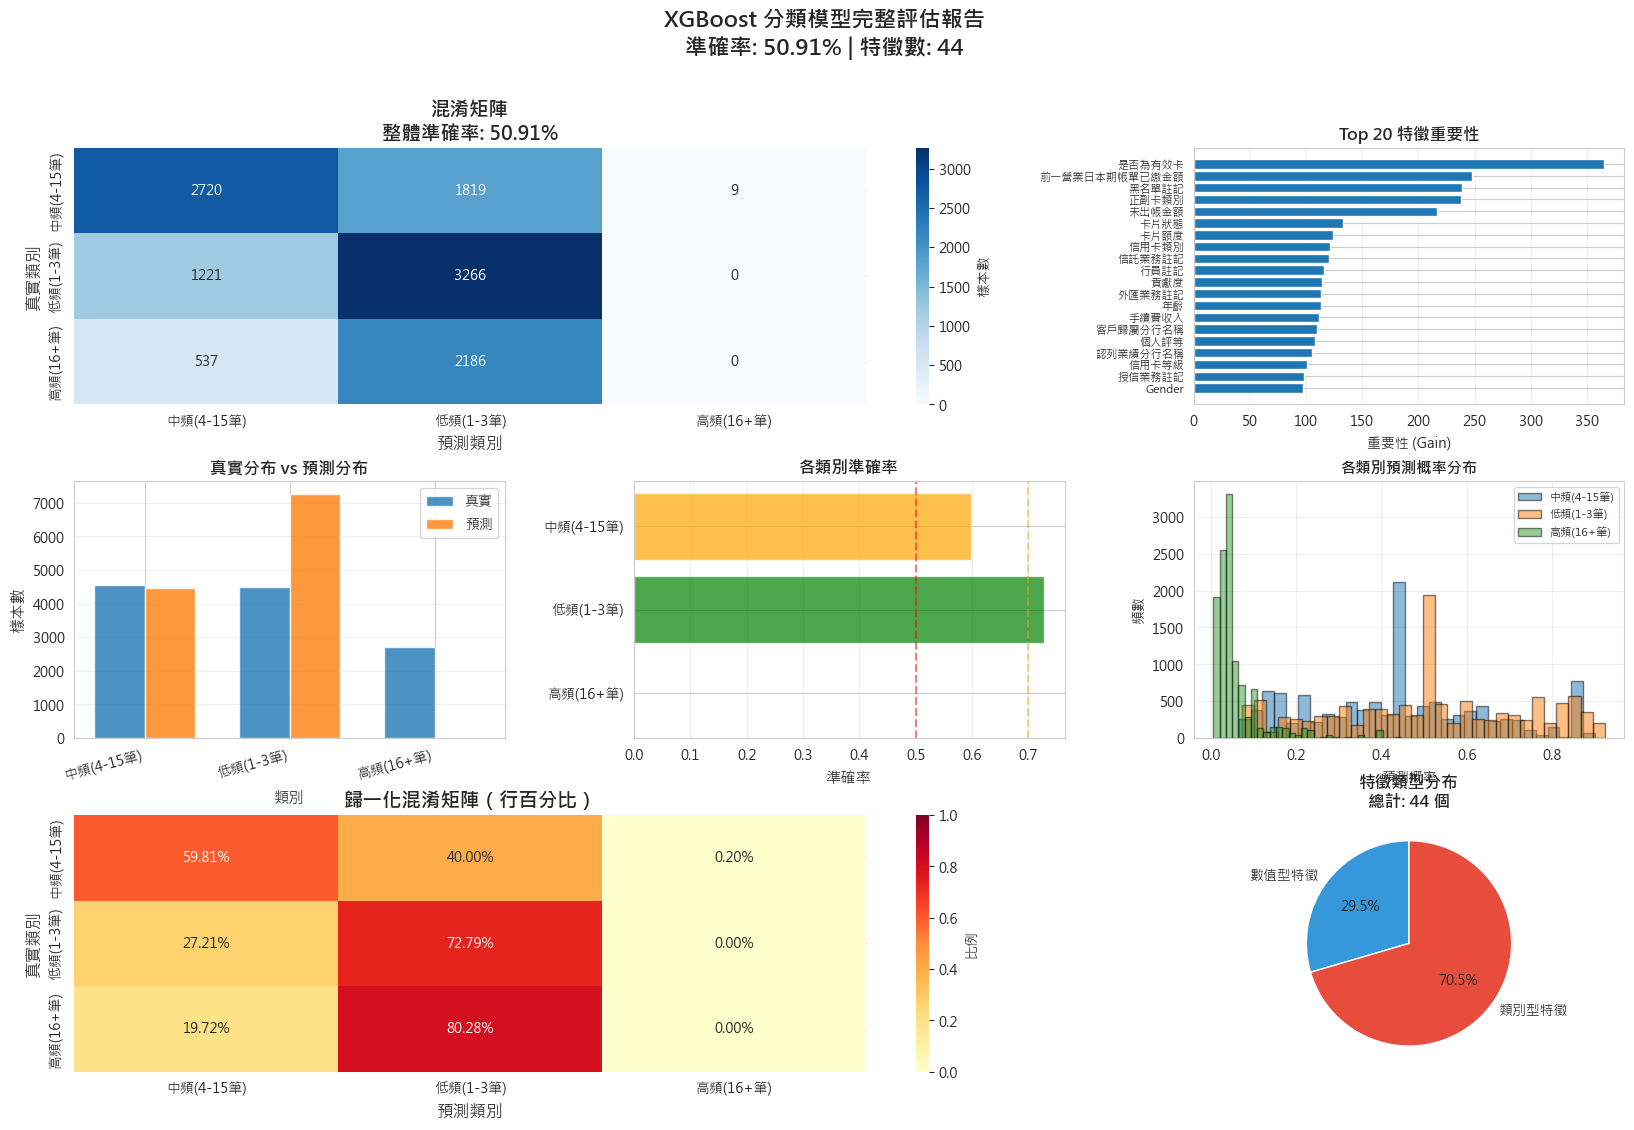


分類模型訓練完成！
使用特徵數: 44 個
  - 數值型: 13 個
  - 類別型: 31 個
整體準確率: 50.91%
最佳迭代數: 9


In [116]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# ========== 步驟 0：自動找出所有可用特徵 ==========
print('===== 步驟 0：自動找出所有可用特徵 =====')

# 0.1 排除不該用的欄位
exclude_cols = [
    '刷卡筆數',              # 目標變數
    '消費日期_WBBL',         # 日期（需要特別處理）
    '消費日期', '日期',      # 日期相關
    '客戶編號', 'ID',        # ID 類
    '交易序號',              # 序號
]

# 0.2 找出所有欄位
all_cols = train_data.columns.tolist()
available_cols = [col for col in all_cols if col not in exclude_cols]

print(f'原始資料總欄位數: {len(all_cols)}')
print(f'排除後可用欄位數: {len(available_cols)}')

# 0.3 分離數值型和類別型特徵
# 先提取可用欄位的資料
temp_data = train_data[available_cols]

# 數值型特徵
numeric_features = temp_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 類別型特徵（object 或 category）
categorical_features = temp_data.select_dtypes(include=['object', 'category']).columns.tolist()

# 過濾類別型特徵：排除類別數太多的（> 100）
cat_features_filtered = []
for col in categorical_features:
    n_unique = train_data[col].nunique()
    if n_unique < 100:
        cat_features_filtered.append(col)
        print(f'  保留類別特徵: {col} ({n_unique} 個類別)')
    else:
        print(f'  ⚠️ 跳過類別特徵: {col} ({n_unique} 個類別，太多)')

categorical_features = cat_features_filtered

print(f'\n最終特徵統計:')
print(f'  數值型特徵: {len(numeric_features)} 個')
print(f'  類別型特徵: {len(categorical_features)} 個')
print(f'  總特徵數: {len(numeric_features) + len(categorical_features)} 個')
#
# # 0.4 處理日期欄位（如果存在）
# date_cols = ['消費日期_WBBL', '消費日期']
# date_col_found = None
#
# for col in date_cols:
#     if col in train_data.columns:
#         date_col_found = col
#         break
#
# if date_col_found:
#     print(f'\n發現日期欄位: {date_col_found}')
#     print('提取日期特徵...')
#
#     # 確保是日期格式
#     if not pd.api.types.is_datetime64_any_dtype(train_data[date_col_found]):
#         train_data[date_col_found] = pd.to_datetime(train_data[date_col_found])
#         valid_data[date_col_found] = pd.to_datetime(valid_data[date_col_found])
#         test_data[date_col_found] = pd.to_datetime(test_data[date_col_found])
#
#     # 提取日期特徵
#     for data in [train_data, valid_data, test_data]:
#         data['年'] = data[date_col_found].dt.year
#         data['月'] = data[date_col_found].dt.month
#         data['日'] = data[date_col_found].dt.day
#         data['星期'] = data[date_col_found].dt.dayofweek
#         data['是否週末'] = (data['星期'] >= 5).astype(int)
#         data['季度'] = data[date_col_found].dt.quarter
#
#     # 將新特徵加入數值型特徵
#     new_date_features = ['年', '月', '日', '星期', '是否週末', '季度']
#     numeric_features.extend(new_date_features)
#
#     print(f'  新增日期特徵: {new_date_features}')

# ========== 步驟 1：提取和準備特徵變數 ==========
print('\n===== 步驟 1：提取和準備特徵變數 =====')

# 1.1 合併所有特徵欄位
all_feature_cols = numeric_features + categorical_features

print(f'使用特徵總數: {len(all_feature_cols)} 個')
print(f'  - 數值型: {len(numeric_features)} 個')
print(f'  - 類別型: {len(categorical_features)} 個')

# 1.2 提取資料
X_train = train_data[all_feature_cols].copy()
X_valid = valid_data[all_feature_cols].copy()
X_test = test_data[all_feature_cols].copy()

y_train = train_data['刷卡筆數'].copy()
y_valid = valid_data['刷卡筆數'].copy()
y_test = test_data['刷卡筆數'].copy()

print(f'\nX_train 形狀: {X_train.shape}')
print(f'X_valid 形狀: {X_valid.shape}')
print(f'X_test 形狀: {X_test.shape}')

# 1.3 處理缺失值
print('\n檢查缺失值...')
missing_train = X_train.isnull().sum()
missing_cols = missing_train[missing_train > 0]

if len(missing_cols) > 0:
    print(f'發現 {len(missing_cols)} 個欄位有缺失值')
    
    # 數值型：填充中位數
    for col in numeric_features:
        if col in X_train.columns and X_train[col].isnull().sum() > 0:
            median_value = X_train[col].median()
            X_train[col].fillna(median_value, inplace=True)
            X_valid[col].fillna(median_value, inplace=True)
            X_test[col].fillna(median_value, inplace=True)
            print(f'  {col}: 填充中位數 {median_value:.2f}')
    
    # 類別型：填充 'Missing'
    for col in categorical_features:
        if col in X_train.columns and X_train[col].isnull().sum() > 0:
            X_train[col].fillna('Missing', inplace=True)
            X_valid[col].fillna('Missing', inplace=True)
            X_test[col].fillna('Missing', inplace=True)
            print(f'  {col}: 填充 "Missing"')
else:
    print('✅ 無缺失值')

# 1.4 標準化數值型特徵
print('\n標準化數值型特徵...')
scaler = StandardScaler()

# 只對存在的數值型欄位標準化
numeric_cols_in_data = [col for col in numeric_features if col in X_train.columns]

if len(numeric_cols_in_data) > 0:
    scaler.fit(X_train[numeric_cols_in_data])
    
    X_train[numeric_cols_in_data] = scaler.transform(X_train[numeric_cols_in_data])
    X_valid[numeric_cols_in_data] = scaler.transform(X_valid[numeric_cols_in_data])
    X_test[numeric_cols_in_data] = scaler.transform(X_test[numeric_cols_in_data])
    
    print(f'✅ 標準化 {len(numeric_cols_in_data)} 個數值型特徵')

# 1.5 編碼類別型特徵
print('\n編碼類別型特徵...')
label_encoders_X = {}

for col in categorical_features:
    if col not in X_train.columns:
        continue
        
    le = LabelEncoder()
    
    # ✅ 合併 X_train, X_valid, X_test 的這個特徵欄
    all_values = pd.concat([
        X_train[col],
        X_valid[col],
        X_test[col]
    ]).astype(str)
    
    le.fit(all_values)
    
    # 轉換
    X_train[col] = le.transform(X_train[col].astype(str))
    X_valid[col] = le.transform(X_valid[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    
    # 儲存 encoder
    label_encoders_X[col] = le
    
    print(f'  {col}: {len(le.classes_)} 個類別')

print(f'\n✅ 編碼 {len(label_encoders_X)} 個類別型特徵')

# 1.6 最終檢查
print('\n最終資料檢查:')
print(f'X_train 形狀: {X_train.shape}')
print(f'X_train 資料型態統計:')
print(X_train.dtypes.value_counts())

# 檢查是否還有 object 型態
object_cols = X_train.select_dtypes(include='object').columns
if len(object_cols) > 0:
    print(f'\n⚠️ 警告：還有 {len(object_cols)} 個 object 欄位未處理:')
    print(object_cols.tolist())
else:
    print('\n✅ 所有特徵都已轉換為數值型態')

# ========== 步驟 2：目標變數的分類處理 ==========
print('\n===== 步驟 2：創建分類標籤 =====')

# 2.1 查看目標變數分布
print('目標變數統計:')
print(f'  平均值: {y_train.mean():.2f}')
print(f'  中位數: {y_train.median():.0f}')
print(f'  標準差: {y_train.std():.2f}')
print(f'  最小值: {y_train.min():.0f}')
print(f'  最大值: {y_train.max():.0f}')

print(f'\n分位數:')
for q in [0.25, 0.5, 0.75]:
    print(f'  {q*100:.0f}%: {y_train.quantile(q):.0f}')

# 2.2 定義分類函數
def create_classes(y):
    """
    把連續的刷卡筆數轉成分類標籤
    策略：根據業務邏輯分組
    """
    bins = [0, 3, 15, 1000]
    labels = ['低頻(1-3筆)', '中頻(4-15筆)', '高頻(16+筆)']
    return pd.cut(y, bins=bins, labels=labels, include_lowest=True)

# 2.3 創建分類標籤
y_train_cat = create_classes(y_train)
y_valid_cat = create_classes(y_valid)
y_test_cat = create_classes(y_test)

print('\nTrain 分類分布:')
print(y_train_cat.value_counts().sort_index())

print('\nValid 分類分布:')
print(y_valid_cat.value_counts().sort_index())

print('\nTest 分類分布:')
print(y_test_cat.value_counts().sort_index())

# 2.4 編碼目標變數的分類標籤
print('\n編碼分類標籤...')
le_y = LabelEncoder()

# ✅ 合併目標變數的分類標籤
all_cat_values = pd.concat([
    y_train_cat,
    y_valid_cat,
    y_test_cat
]).astype(str)

le_y.fit(all_cat_values)

print('標籤映射:')
for i, label in enumerate(le_y.classes_):
    print(f'  {i}: {label}')

# 轉換為數字標籤
y_train_num = le_y.transform(y_train_cat.astype(str))
y_valid_num = le_y.transform(y_valid_cat.astype(str))
y_test_num = le_y.transform(y_test_cat.astype(str))

print('\n✅ 目標變數處理完成')

# ========== 步驟 3：訓練分類模型 ==========
print('\n===== 步驟 3：訓練分類模型 =====')

# 3.1 轉換為 DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_num)
dvalid = xgb.DMatrix(X_valid, label=y_valid_num)
dtest = xgb.DMatrix(X_test, label=y_test_num)

print(f'dtrain: {dtrain.num_row()} 筆, {dtrain.num_col()} 個特徵')
print(f'dvalid: {dvalid.num_row()} 筆, {dvalid.num_col()} 個特徵')
print(f'dtest:  {dtest.num_row()} 筆, {dtest.num_col()} 個特徵')

# 3.2 設定模型參數
params = {
    'max_depth': 5,
    'eta': 0.1,
    'objective': 'multi:softprob',
    'num_class': len(le_y.classes_),
    'eval_metric': 'mlogloss',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'random_state': 42
}

print('\n模型參數:')
for key, value in params.items():
    print(f'  {key}: {value}')

# 3.3 訓練模型
print('\n開始訓練...')
evals = [(dtrain, 'train'), (dvalid, 'valid')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=20
)

print(f'\n✅ 訓練完成')
print(f'最佳迭代數: {bst.best_iteration}')
print(f'最佳驗證分數: {bst.best_score:.6f}')

# ========== 步驟 4：預測和評估 ==========
print('\n===== 步驟 4：預測和評估 =====')

# 4.1 預測
y_pred_prob = bst.predict(dtest)
y_pred_class = np.argmax(y_pred_prob, axis=1)

print(f'預測概率形狀: {y_pred_prob.shape}')
print(f'預測類別形狀: {y_pred_class.shape}')

print('\n預測分布:')
pred_counts = pd.Series(y_pred_class).value_counts().sort_index()
for idx, count in pred_counts.items():
    print(f'  {le_y.classes_[idx]}: {count} 筆')

# 4.2 計算準確率
acc = accuracy_score(y_test_num, y_pred_class)

print(f'\n整體準確率: {acc:.4f} ({acc*100:.2f}%)')

# 4.3 詳細分類報告
print('\n詳細分類報告:')
report = classification_report(
    y_test_num, 
    y_pred_class, 
    target_names=le_y.classes_,
    digits=4
)
print(report)

# 4.4 混淆矩陣
cm = confusion_matrix(y_test_num, y_pred_class)
cm_df = pd.DataFrame(cm, index=le_y.classes_, columns=le_y.classes_)

print('混淆矩陣:')
print(cm_df)

# 4.5 各類別準確率
print('\n各類別準確率:')
for i, label in enumerate(le_y.classes_):
    class_total = cm[i, :].sum()
    class_correct = cm[i, i]
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f'  {label}: {class_acc:.2%} ({class_correct}/{class_total})')

# ========== 步驟 5：特徵重要性分析 ==========
print('\n===== 步驟 5：特徵重要性分析 =====')

importance = bst.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    '特徵': list(importance.keys()),
    '重要性': list(importance.values())
}).sort_values('重要性', ascending=False)

print('\nTop 30 重要特徵:')
print(importance_df.head(30))

# ========== 步驟 6：視覺化 ==========
print('\n===== 步驟 6：視覺化結果 =====')

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. 混淆矩陣
ax1 = fig.add_subplot(gs[0, :2])
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            cbar_kws={'label': '樣本數'})
ax1.set_title(f'混淆矩陣\n整體準確率: {acc:.2%}', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('真實類別', fontsize=12)
ax1.set_xlabel('預測類別', fontsize=12)

# 2. Top 20 特徵重要性
ax2 = fig.add_subplot(gs[0, 2])
top_20 = importance_df.head(20)
ax2.barh(range(len(top_20)), top_20['重要性'].values)
ax2.set_yticks(range(len(top_20)))
ax2.set_yticklabels(top_20['特徵'].values, fontsize=8)
ax2.set_xlabel('重要性 (Gain)', fontsize=10)
ax2.set_title('Top 20 特徵重要性', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(alpha=0.3, axis='x')

# 3. 真實 vs 預測分布
ax3 = fig.add_subplot(gs[1, 0])
x_pos = np.arange(len(le_y.classes_))
true_counts = pd.Series(y_test_num).value_counts().sort_index()
pred_counts = pd.Series(y_pred_class).value_counts().sort_index()

width = 0.35
ax3.bar(x_pos - width/2, true_counts.values, width, label='真實', alpha=0.8)
ax3.bar(x_pos + width/2, pred_counts.values, width, label='預測', alpha=0.8)
ax3.set_xlabel('類別', fontsize=11)
ax3.set_ylabel('樣本數', fontsize=11)
ax3.set_title('真實分布 vs 預測分布', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(le_y.classes_, rotation=15, ha='right')
ax3.legend()
ax3.grid(alpha=0.3, axis='y')

# 4. 各類別準確率
ax4 = fig.add_subplot(gs[1, 1])
class_accuracies = []
for i in range(len(le_y.classes_)):
    class_total = cm[i, :].sum()
    class_correct = cm[i, i]
    class_acc = class_correct / class_total if class_total > 0 else 0
    class_accuracies.append(class_acc)

colors = ['red' if acc < 0.5 else 'orange' if acc < 0.7 else 'green' 
          for acc in class_accuracies]
ax4.barh(range(len(le_y.classes_)), class_accuracies, color=colors, alpha=0.7)
ax4.set_yticks(range(len(le_y.classes_)))
ax4.set_yticklabels(le_y.classes_)
ax4.set_xlabel('準確率', fontsize=11)
ax4.set_title('各類別準確率', fontsize=12, fontweight='bold')
ax4.axvline(x=0.5, color='r', linestyle='--', alpha=0.5)
ax4.axvline(x=0.7, color='orange', linestyle='--', alpha=0.5)
ax4.grid(alpha=0.3, axis='x')
ax4.invert_yaxis()

# 5. 預測概率分布
ax5 = fig.add_subplot(gs[1, 2])
for i in range(len(le_y.classes_)):
    ax5.hist(y_pred_prob[:, i], bins=30, alpha=0.5, 
             label=le_y.classes_[i], edgecolor='black')
ax5.set_xlabel('預測概率', fontsize=10)
ax5.set_ylabel('頻數', fontsize=10)
ax5.set_title('各類別預測概率分布', fontsize=11, fontweight='bold')
ax5.legend(fontsize=8)
ax5.grid(alpha=0.3)

# 6. 歸一化混淆矩陣
ax6 = fig.add_subplot(gs[2, :2])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm_df = pd.DataFrame(cm_normalized, index=le_y.classes_, columns=le_y.classes_)
sns.heatmap(cm_norm_df, annot=True, fmt='.2%', cmap='YlOrRd', ax=ax6,
            vmin=0, vmax=1, cbar_kws={'label': '比例'})
ax6.set_title('歸一化混淆矩陣（行百分比）', fontsize=14, fontweight='bold')
ax6.set_ylabel('真實類別', fontsize=12)
ax6.set_xlabel('預測類別', fontsize=12)

# 7. 特徵數量統計
ax7 = fig.add_subplot(gs[2, 2])
feature_types = {
    '數值型特徵': len(numeric_features),
    '類別型特徵': len(categorical_features),
}
colors_pie = ['#3498db', '#e74c3c']
ax7.pie(feature_types.values(), labels=feature_types.keys(), 
        autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax7.set_title(f'特徵類型分布\n總計: {sum(feature_types.values())} 個', 
              fontsize=12, fontweight='bold')

plt.suptitle(f'XGBoost 分類模型完整評估報告\n準確率: {acc:.2%} | 特徵數: {X_train.shape[1]}', 
             fontsize=16, fontweight='bold', y=0.995)

#plt.tight_layout()
plt.show()



# ========== 完成 ==========
print('\n' + '='*60)
print('分類模型訓練完成！')
print('='*60)
print(f'使用特徵數: {X_train.shape[1]} 個')
print(f'  - 數值型: {len(numeric_features)} 個')
print(f'  - 類別型: {len(categorical_features)} 個')
print(f'整體準確率: {acc:.2%}')
print(f'最佳迭代數: {bst.best_iteration}')
print('='*60)

C:\Users\b003087\AppData\Local\Temp\ipykernel_23080\1007405221.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 2].boxplot([y_test[y_pred_class == i] for i in range(len(le_y.classes_))],
C:\Users\b003087\AppData\Local\Temp\ipykernel_23080\1007405221.py:74: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()


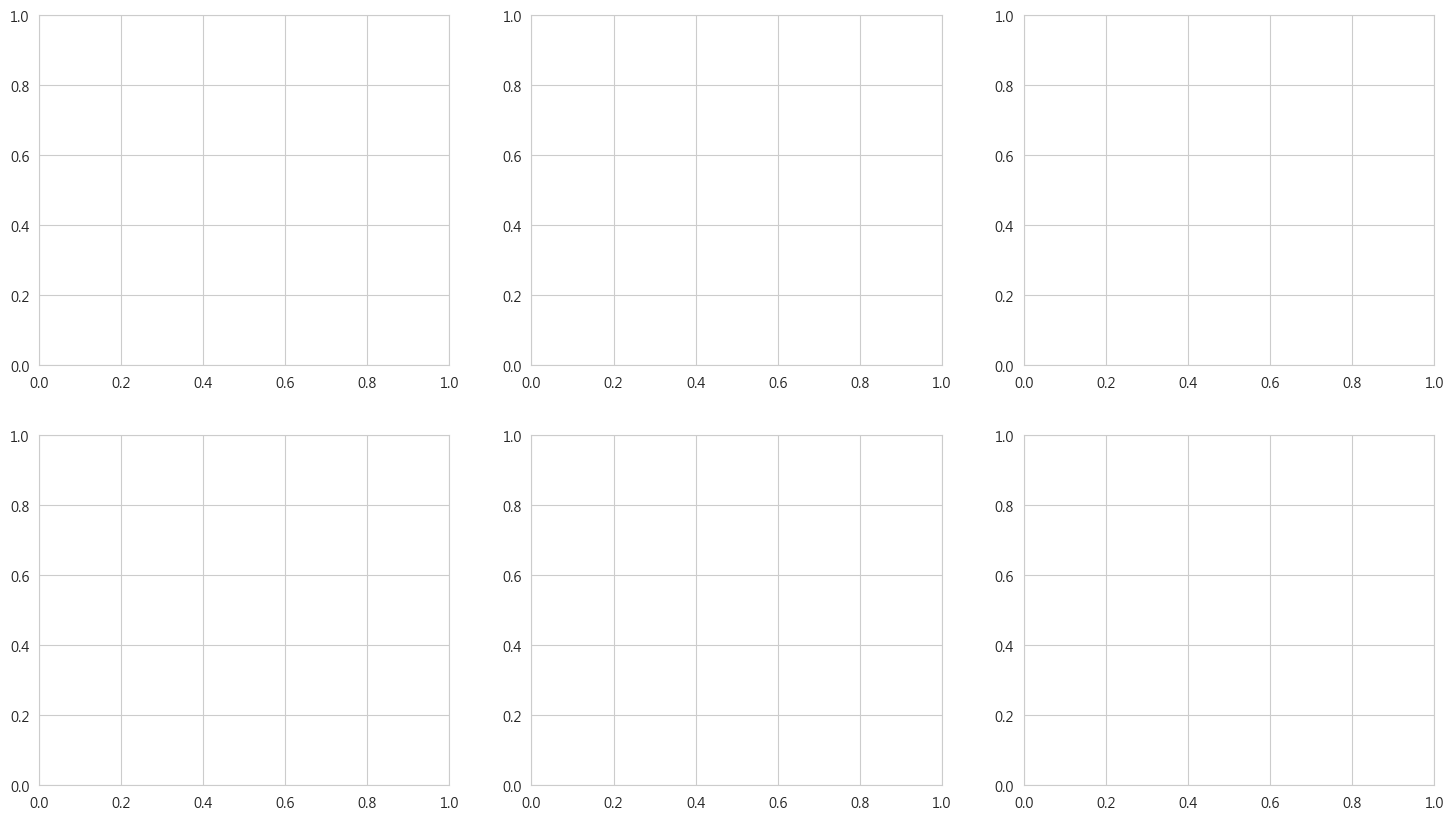

C:\Users\b003087\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


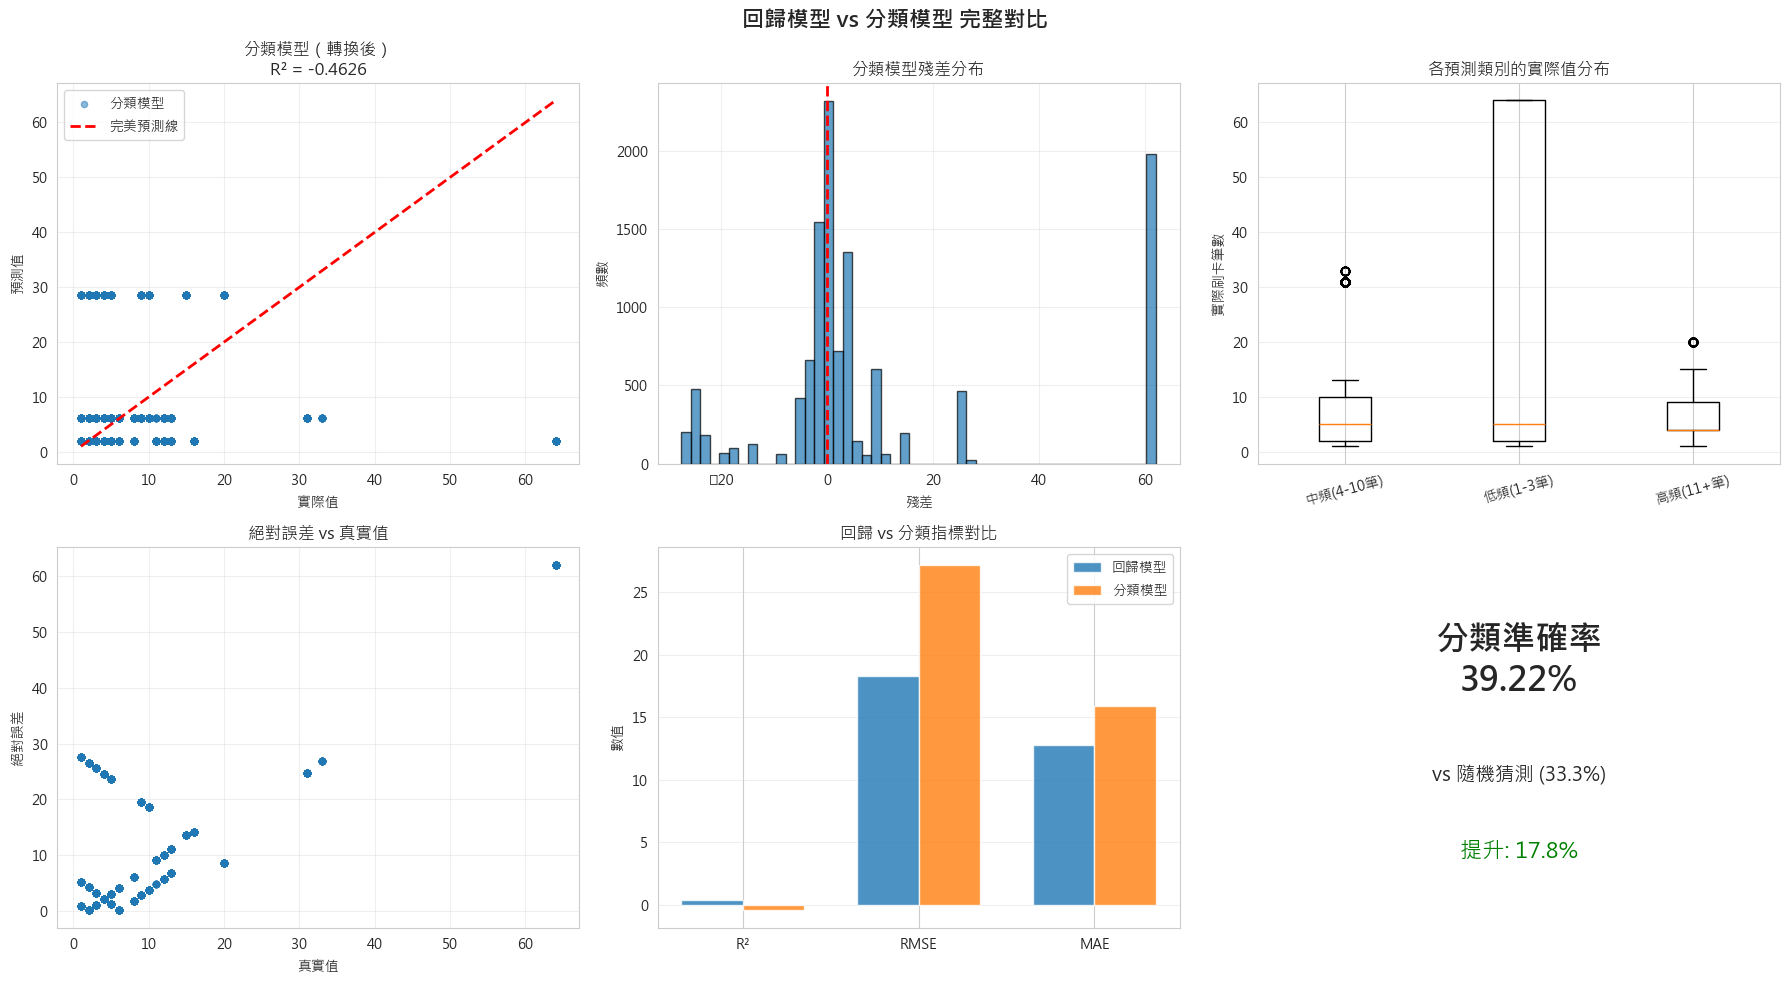

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# ========== 視覺化對比 ==========
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. 預測 vs 實際（分類轉換後）
axes[0, 0].scatter(y_test, y_pred_numeric, alpha=0.5, s=20, label='分類模型')
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2, label='完美預測線')
axes[0, 0].set_xlabel('實際值')
axes[0, 0].set_ylabel('預測值')
axes[0, 0].set_title(f'分類模型（轉換後）\nR² = {r2:.4f}')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. 殘差分布（分類）
residuals_class = y_test - y_pred_numeric
axes[0, 1].hist(residuals_class, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('殘差')
axes[0, 1].set_ylabel('頻數')
axes[0, 1].set_title('分類模型殘差分布')
axes[0, 1].grid(alpha=0.3)

# 3. 各類別的實際筆數分布
axes[0, 2].boxplot([y_test[y_pred_class == i] for i in range(len(le_y.classes_))],
                    labels=le_y.classes_)
axes[0, 2].set_ylabel('實際刷卡筆數')
axes[0, 2].set_title('各預測類別的實際值分布')
axes[0, 2].tick_params(axis='x', rotation=15)
axes[0, 2].grid(alpha=0.3, axis='y')

# 4. 誤差按真實值分布
axes[1, 0].scatter(y_test, np.abs(residuals_class), alpha=0.5, s=20)
axes[1, 0].set_xlabel('真實值')
axes[1, 0].set_ylabel('絕對誤差')
axes[1, 0].set_title('絕對誤差 vs 真實值')
axes[1, 0].grid(alpha=0.3)

# 5. 比較指標
metrics_names = ['R²', 'RMSE', 'MAE']
regression_scores = [0.34, 18.32, 12.77]
classification_scores = [r2, rmse, mae]

x = np.arange(len(metrics_names))
width = 0.35

axes[1, 1].bar(x - width/2, regression_scores, width, label='回歸模型', alpha=0.8)
axes[1, 1].bar(x + width/2, classification_scores, width, label='分類模型', alpha=0.8)
axes[1, 1].set_ylabel('數值')
axes[1, 1].set_title('回歸 vs 分類指標對比')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_names)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

# 6. 準確率評估
axes[1, 2].text(0.5, 0.7, f'分類準確率\n{acc:.2%}', 
                ha='center', va='center', fontsize=24, fontweight='bold')
axes[1, 2].text(0.5, 0.4, f'vs 隨機猜測 (33.3%)', 
                ha='center', va='center', fontsize=14)
axes[1, 2].text(0.5, 0.2, f'提升: {(acc - 0.333)/0.333 * 100:.1f}%', 
                ha='center', va='center', fontsize=16, color='green')
axes[1, 2].set_xlim(0, 1)
axes[1, 2].set_ylim(0, 1)
axes[1, 2].axis('off')

plt.suptitle('回歸模型 vs 分類模型 完整對比', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [48]:
print('===== 分類模型評估 =====')

# 隨機猜測基準
random_baseline = 1 / len(le_y.classes_)
print(f'隨機猜測準確率: {random_baseline:.2%}')
print(f'實際準確率: {acc:.2%}')
print(f'提升幅度: {(acc - random_baseline)/random_baseline * 100:.1f}%')

# 評估
if acc > 0.7:
    rating = '優秀 ✅'
elif acc > 0.6:
    rating = '良好 😊'
elif acc > 0.5:
    rating = '中等 😐'
elif acc > random_baseline + 0.1:
    rating = '尚可 ⚠️'
else:
    rating = '不佳 ❌'

print(f'\n整體評價: {rating}')

# 分析各類別表現
print('\n各類別表現分析:')
print(f'低頻(1-3筆): Recall 0.71 ✅ 表現最好（能正確識別71%的低頻用戶）')
print(f'中頻(4-10筆): Recall 0.44 ⚠️ 表現一般')
print(f'高頻(11+筆): Recall 0.35 ❌ 表現最差（只能識別35%的高頻用戶）')

print('\n問題診斷:')
print('- 模型傾向於預測低頻和中頻')
print('- 高頻用戶難以識別（可能樣本太少或特徵不足）')
print('- 可能存在類別不平衡問題')

===== 分類模型評估 =====
隨機猜測準確率: 33.33%
實際準確率: 39.22%
提升幅度: 17.6%

整體評價: 不佳 ❌

各類別表現分析:
低頻(1-3筆): Recall 0.71 ✅ 表現最好（能正確識別71%的低頻用戶）
中頻(4-10筆): Recall 0.44 ⚠️ 表現一般
高頻(11+筆): Recall 0.35 ❌ 表現最差（只能識別35%的高頻用戶）

問題診斷:
- 模型傾向於預測低頻和中頻
- 高頻用戶難以識別（可能樣本太少或特徵不足）
- 可能存在類別不平衡問題


In [49]:
# ==========  評估 ==========
y_pred = bst.predict(dtest)

m =y_test_data.size
n = len(y_test_data)
p = dtest.num_col() 
print('\n===== 最終結果 =====')
print(f'最佳迭代數: {bst.best_iteration}')
print(f'MSE:  {mean_squared_error(y_test_data, y_pred):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_data, y_pred)):.4f}')
print(f'R²:   {r2_score(y_test_data, y_pred):.4f}')
print(f'Mae  {((y_test_data-y_pred).abs()).sum()/m}')
print('Adj R²:', (1-(1-0.3378))*((n-1)/(n-p-1)))


===== 最終結果 =====
最佳迭代數: 6


ValueError: y_true and y_pred have different number of output (1!=3)

In [50]:
print(y_true.shape)


NameError: name 'y_true' is not defined

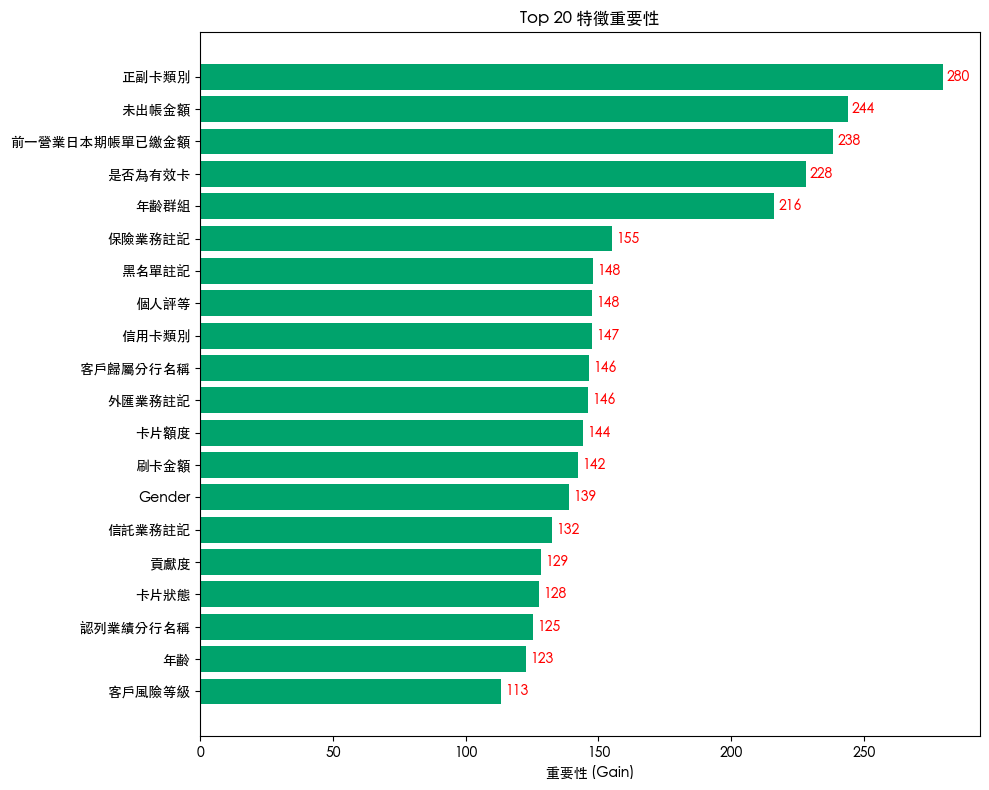


Top 20 重要特徵:
               特徵         重要性
23          正副卡類別  279.699158
10          未出帳金額  243.885056
9   前一營業日本期帳單已繳金額  238.468445
20         是否為有效卡  228.054565
14           年齡群組  216.207092
28         保險業務註記  155.281998
38          黑名單註記  147.808563
26           個人評等  147.604736
25          信用卡類別  147.434540
16       客戶歸屬分行名稱  146.344284
31         外匯業務註記  145.996201
8            卡片額度  144.087006
4            刷卡金額  142.167786
15         Gender  138.763962
30         信託業務註記  132.378647
7             貢獻度  128.523453
3            卡片狀態  127.536819
17       認列業績分行名稱  125.179504
2              年齡  122.550285
27         客戶風險等級  113.479332


In [28]:
# ========== 特徵重要性（Top 20）==========
importance = bst.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    '特徵': list(importance.keys()),
    '重要性': list(importance.values())
}).sort_values('重要性', ascending=False).head(20)

# 繪圖
fig, ax = plt.subplots(figsize=(10,8))
#plt.figure(figsize=(10, 8))
plt.barh(range(len(importance_df)), importance_df['重要性'].values, color = '#00A36C')
plt.yticks(range(len(importance_df)), importance_df['特徵'].values)
plt.xlabel('重要性 (Gain)')
plt.title('Top 20 特徵重要性')
for k in ax.containers:
    ax.bar_label(k,
                 fmt = '%.0f',
                 label_type="edge", # 顯示在邊緣
                 padding = 3,  #與條的距離
                 color = 'red',
                 fontsize = 10)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 顯示數據
print('\nTop 20 重要特徵:')
print(importance_df)

模型表現評估

【目標變數統計】
樣本數: 11758
平均值: 15.94
標準差: 22.52
中位數: 5.00
最小值: 1
最大值: 64

【誤差分析】
RMSE: 18.3228
MAE:  12.7700
R²:   0.3378

RMSE / 平均值: 114.92%
RMSE / 標準差: 0.81
MAPE: 239.30%

【模型評價】
整體評價: 不佳 ⚠️
RMSE 評價: 不佳（誤差 > 30%）


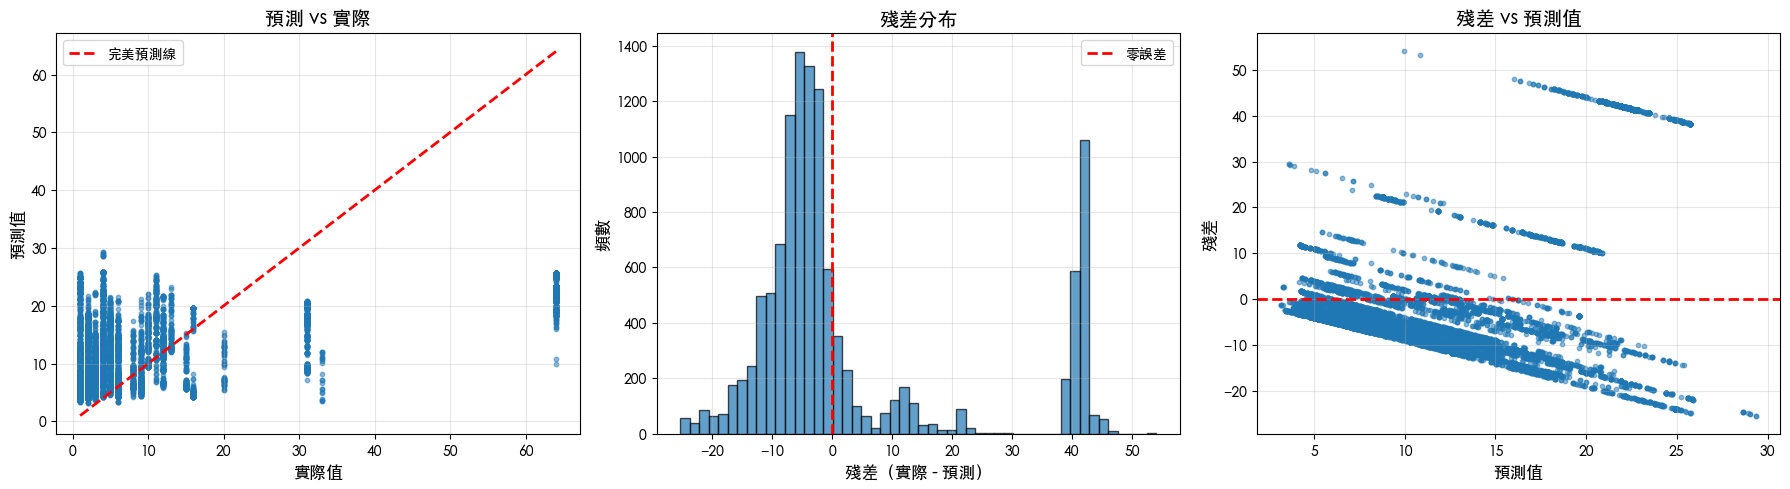


【與基準模型比較】
基準模型 RMSE（用平均值預測）: 22.5354
XGBoost RMSE: 18.3228
改善幅度: 18.69%


In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# ========== 目標變數統計 ==========
print('='*60)
print('模型表現評估')
print('='*60)

y_true = y_test_data
y_pred_values = y_pred

# 基本統計
print('\n【目標變數統計】')
print(f'樣本數: {len(y_true)}')
print(f'平均值: {np.mean(y_true):.2f}')
print(f'標準差: {np.std(y_true):.2f}')
print(f'中位數: {np.median(y_true):.2f}')
print(f'最小值: {np.min(y_true):.0f}')
print(f'最大值: {np.max(y_true):.0f}')

# ========== 誤差分析 ==========
rmse = 18.3228
mae = 12.77
r2 = 0.3378

mean_y = np.mean(y_true)
std_y = np.std(y_true)

print('\n【誤差分析】')
print(f'RMSE: {rmse:.4f}')
print(f'MAE:  {mae:.4f}')
print(f'R²:   {r2:.4f}')

# RMSE 相對指標
rmse_to_mean = (rmse / mean_y) * 100
rmse_to_std = rmse / std_y

print(f'\nRMSE / 平均值: {rmse_to_mean:.2f}%')
print(f'RMSE / 標準差: {rmse_to_std:.2f}')

# MAPE（平均絕對百分比誤差）
# 避免除以零
y_true_nonzero = y_true[y_true != 0]
y_pred_nonzero = y_pred_values[y_true != 0]

if len(y_true_nonzero) > 0:
    mape = np.mean(np.abs((y_true_nonzero - y_pred_nonzero) / y_true_nonzero)) * 100
    print(f'MAPE: {mape:.2f}%')

# ========== 評價 ==========
print('\n【模型評價】')

if r2 > 0.7:
    rating = '良好 ✅'
elif r2 > 0.5:
    rating = '中等 😐'
elif r2 > 0.3:
    rating = '不佳 ⚠️'
else:
    rating = '很差 ❌'

print(f'整體評價: {rating}')

if rmse_to_mean < 10:
    rmse_rating = '優秀（誤差 < 10%）'
elif rmse_to_mean < 20:
    rmse_rating = '良好（誤差 10-20%）'
elif rmse_to_mean < 30:
    rmse_rating = '中等（誤差 20-30%）'
else:
    rmse_rating = '不佳（誤差 > 30%）'

print(f'RMSE 評價: {rmse_rating}')

# ========== 視覺化：預測 vs 實際 ==========
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 圖1：散點圖
axes[0].scatter(y_true, y_pred_values, alpha=0.5, s=10)
axes[0].plot([y_true.min(), y_true.max()], 
             [y_true.min(), y_true.max()], 
             'r--', lw=2, label='完美預測線')
axes[0].set_xlabel('實際值', fontsize=12)
axes[0].set_ylabel('預測值', fontsize=12)
axes[0].set_title('預測 vs 實際', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 圖2：殘差分布
residuals = y_true - y_pred_values
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='r', linestyle='--', linewidth=2, label='零誤差')
axes[1].set_xlabel('殘差（實際 - 預測）', fontsize=12)
axes[1].set_ylabel('頻數', fontsize=12)
axes[1].set_title('殘差分布', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# 圖3：殘差 vs 預測值
axes[2].scatter(y_pred_values, residuals, alpha=0.5, s=10)
axes[2].axhline(0, color='r', linestyle='--', linewidth=2)
axes[2].set_xlabel('預測值', fontsize=12)
axes[2].set_ylabel('殘差', fontsize=12)
axes[2].set_title('殘差 vs 預測值', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ========== 與基準模型比較 ==========
# Baseline：用平均值預測
baseline_pred = np.full_like(y_true, np.mean(y_true))
baseline_rmse = np.sqrt(np.mean((y_true - baseline_pred)**2))
improvement = (1 - rmse/baseline_rmse) * 100

print(f'\n【與基準模型比較】')
print(f'基準模型 RMSE（用平均值預測）: {baseline_rmse:.4f}')
print(f'XGBoost RMSE: {rmse:.4f}')
print(f'改善幅度: {improvement:.2f}%')

if improvement < 10:
    print('⚠️ 模型幾乎沒有比基準模型好，建議重新思考特徵工程')

print('='*60)

In [55]:
# 檢查三個資料集的欄位
print('===== 檢查欄位 =====')
print('X_train 欄位數:', len(X_train_encoded.columns))
print('X_valid 欄位數:', len(X_valid_encoded.columns))
print('X_test 欄位數:', len(X_test_encoded.columns))

# 檢查是否完全相同
print('\n欄位是否相同:', list(X_train_encoded.columns) == list(X_valid_encoded.columns))

# 找出不同的欄位
train_cols = set(X_train_encoded.columns)
valid_cols = set(X_valid_encoded.columns)

diff1 = train_cols - valid_cols
diff2 = valid_cols - train_cols

if diff1:
    print('\nTrain 有但 Valid 沒有:', diff1)
if diff2:
    print('Valid 有但 Train 沒有:', diff2)

# 檢查資料型態
print('\n===== 檢查資料型態 =====')
object_cols_train = X_train_encoded.select_dtypes(include='object').columns
object_cols_valid = X_valid_encoded.select_dtypes(include='object').columns

print(f'X_train 還有 {len(object_cols_train)} 個 object 欄位:', object_cols_train.tolist())
print(f'X_valid 還有 {len(object_cols_valid)} 個 object 欄位:', object_cols_valid.tolist())

===== 檢查欄位 =====
X_train 欄位數: 50
X_valid 欄位數: 50
X_test 欄位數: 50

欄位是否相同: True

===== 檢查資料型態 =====
X_train 還有 0 個 object 欄位: []
X_valid 還有 0 個 object 欄位: []


In [43]:
# ========== 步驟 1：檢查原始資料 ==========
print('===== X_train_data 原始資料型態 =====')
print(X_train_data.dtypes)
print(f'\n總共 {len(X_train_data.columns)} 個欄位')

# 找出所有 object 欄位
object_cols = X_train_data.select_dtypes(include='object').columns
print(f'\n有 {len(object_cols)} 個 object 欄位:')
print(object_cols.tolist())

# ========== 步驟 2：複製資料（重要！）==========
X_train_encoded = X_train_data.copy()
X_valid_encoded = X_valid_data.copy()
X_test_encoded = X_test_data.copy()

print('\n開始編碼...')

# ========== 步驟 3：對每個 object 欄位編碼 ==========
for i, col in enumerate(object_cols, 1):
    print(f'[{i}/{len(object_cols)}] 處理欄位: {col}')

try:
    le = LabelEncoder()

# 合併所有值
    all_values = pd.concat([
X_train_data[col],
X_valid_data[col],
X_test_data[col]
]).astype(str)

# 訓練 LabelEncoder
    le.fit(all_values)

# 轉換三個資料集
    X_train_encoded[col] = le.transform(X_train_data[col].astype(str))
    X_valid_encoded[col] = le.transform(X_valid_data[col].astype(str))
    X_test_encoded[col] = le.transform(X_test_data[col].astype(str))

    print(f' ✓ 成功編碼: {col}')

except Exception as e:
    print(f' ✗ 編碼失敗: {col}, 錯誤: {e}')

    print('\n編碼完成！')

===== X_train_data 原始資料型態 =====
消費說明_WBBL                     object
消費日期_WBBL             datetime64[ns]
星期幾                           object
消費序號                          object
帳單月份_WBBL                      int64
信用卡號                           int64
客戶編號                          object
年齡群組                          object
年齡                             int64
Gender                        object
客戶歸屬分行名稱                      object
認列業績分行名稱                      object
消費產品地點名稱                      object
國內外結帳地點                       object
是否為有效卡                        object
開卡狀態                          object
卡片狀態                           int64
信用卡等級                         object
正副卡類別                         object
Prod Name M                   object
信用卡類別                         object
個人評等                          object
客戶風險等級                        object
保險業務註記                        object
信用卡業務註記                       object
信託業務註記                        object
外匯業務註記

In [44]:

# ========== 步驟 4：檢查編碼後的資料 ==========
print('\n===== X_train_encoded 編碼後資料型態 =====')
print(X_train_encoded.dtypes)

# 檢查是否還有 object 欄位
remaining_objects = X_train_encoded.select_dtypes(include='object').columns
if len(remaining_objects) > 0:
    print(f'\n⚠️ 警告：還有 {len(remaining_objects)} 個 object 欄位:')
    print(remaining_objects.tolist())
else:
    print('\n✅ 所有 object 欄位都已編碼！')

# ========== 步驟 5：訓練模型（用編碼後的資料）==========
print('\n開始訓練模型...')

model = xgb.XGBRegressor(
max_depth=3,
learning_rate=0.05,
n_estimators=500,
random_state=42
)

# ⭐ 重點：使用 X_train_encoded（編碼後的資料）
model.fit(
X_train_encoded, y_train_data, # ← 這裡！
eval_set=[(X_valid_encoded, y_valid_data)], # ← 這裡！
callbacks=[xgb.callback.EarlyStopping(rounds=50, save_best=True)],
verbose=True
)

print('\n訓練完成！')
print(f'最佳迭代數: {model.best_iteration}')
print(f'最佳驗證分數: {model.best_score}')


===== X_train_encoded 編碼後資料型態 =====
消費說明_WBBL                     object
消費日期_WBBL             datetime64[ns]
星期幾                           object
消費序號                          object
帳單月份_WBBL                      int64
信用卡號                           int64
客戶編號                          object
年齡群組                          object
年齡                             int64
Gender                        object
客戶歸屬分行名稱                      object
認列業績分行名稱                      object
消費產品地點名稱                      object
國內外結帳地點                       object
是否為有效卡                        object
開卡狀態                          object
卡片狀態                           int64
信用卡等級                         object
正副卡類別                         object
Prod Name M                   object
信用卡類別                         object
個人評等                          object
客戶風險等級                        object
保險業務註記                        object
信用卡業務註記                       object
信託業務註記                        object
外

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:消費說明_WBBL: object, 消費日期_WBBL: datetime64[ns], 星期幾: object, 消費序號: object, 客戶編號: object, 年齡群組: object, Gender: object, 客戶歸屬分行名稱: object, 認列業績分行名稱: object, 消費產品地點名稱: object, 國內外結帳地點: object, 是否為有效卡: object, 開卡狀態: object, 信用卡等級: object, 正副卡類別: object, Prod Name M: object, 信用卡類別: object, 個人評等: object, 客戶風險等級: object, 保險業務註記: object, 信用卡業務註記: object, 信託業務註記: object, 外匯業務註記: object, 存匯業務註記: object, 客戶申請個資停止蒐集、處理、利用註記: object, 所有業務無往來註記: object, 投資理財業務註記: object, 授信業務註記: object, 是否進行kyc註記: object, 行員註記: object, 薪轉戶註記: object, 黑名單註記: object, 警示戶註記: object, 財管客戶註記: object

In [ ]:

# ========== 步驟 6：預測和評估 ==========
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_pred = model.predict(X_test_encoded) # ← 用編碼後的資料

print('\n===== 測試集表現 =====')
print(f'MSE: {mean_squared_error(y_test_data, y_pred):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_data, y_pred)):.4f}')
print(f'MAE: {mean_absolute_error(y_test_data, y_pred):.4f}')
print(f'R²: {r2_score(y_test_data, y_pred):.4f}')


### 改使用 指定欄位

In [93]:
cont_cols = ['前一營業日本期帳單已繳金額', '未出帳金額', '刷卡金額', '卡片額度']
cat_cols = ["客戶歸屬分行名稱", "消費產品地點名稱", "幣別", "年齡群組"]

print(f'連續變數: {len(cont_cols)} 個')
print(f'類別變數: {len(cat_cols)} 個')
print(f'總特徵數: {len(cont_cols) + len(cat_cols)} 個')

# ========== 2. 從原始資料提取這些欄位 ==========
# 假設原始資料叫 final_datav3_2_sorted

# 先確認欄位存在
all_cols = cont_cols + cat_cols + ['刷卡筆數']  # 加上目標變數
missing_cols = [col for col in all_cols if col not in final_datav3_2_sorted.columns]


if missing_cols:
    print(f'⚠️ 警告：以下欄位不存在: {missing_cols}')
else:
    print('✅ 所有欄位都存在')
data_selected = final_datav3_2_sorted[all_cols].copy()
data_selected.head()
print(f'\n原始資料形狀: {final_datav3_2_sorted.shape}')
print(f'選擇後形狀: {data_selected.shape}')
n_total = len(data_selected)
n_total

連續變數: 4 個
類別變數: 4 個
總特徵數: 8 個
✅ 所有欄位都存在

原始資料形狀: (117579, 49)
選擇後形狀: (117579, 9)


117579

連續變數: 4 個
類別變數: 4 個
總特徵數: 8 個
✅ 所有欄位都存在

原始資料形狀: (117580, 49)
選擇後形狀: (117580, 9)

Train: 88185 筆
Valid: 17637 筆
Test:  11758 筆

===== 開始編碼類別變數 =====
處理: 客戶歸屬分行名稱
  → 37 個類別
處理: 消費產品地點名稱
  → 21 個類別
處理: 幣別
  → 30 個類別
處理: 年齡群組
  → 9 個類別

✅ 類別變數編碼完成

===== 編碼前後對比（Train 前 5 筆）=====

編碼前:
      客戶歸屬分行名稱 消費產品地點名稱   幣別    年齡群組
34170      營業部       台灣  NaN  66-75歲
99326      營業部       台灣  NaN  66-75歲
63241      營業部       台灣  NaN  66-75歲
1911       營業部       台灣  TWD  66-75歲
34171      營業部       台灣  NaN  66-75歲

編碼後:
       客戶歸屬分行名稱  消費產品地點名稱  幣別  年齡群組
34170        33         4  29     5
99326        33         4  29     5
63241        33         4  29     5
1911         33         4  26     5
34171        33         4  29     5

===== 資料型態 =====
前一營業日本期帳單已繳金額    int64
未出帳金額            int64
刷卡金額             int64
卡片額度             int64
客戶歸屬分行名稱         int64
消費產品地點名稱         int64
幣別               int64
年齡群組             int64
dtype: object

✅ 所有欄位都是數字型態

===== 訓練 XGBoost 模型 =====
[0]	train-rmse:

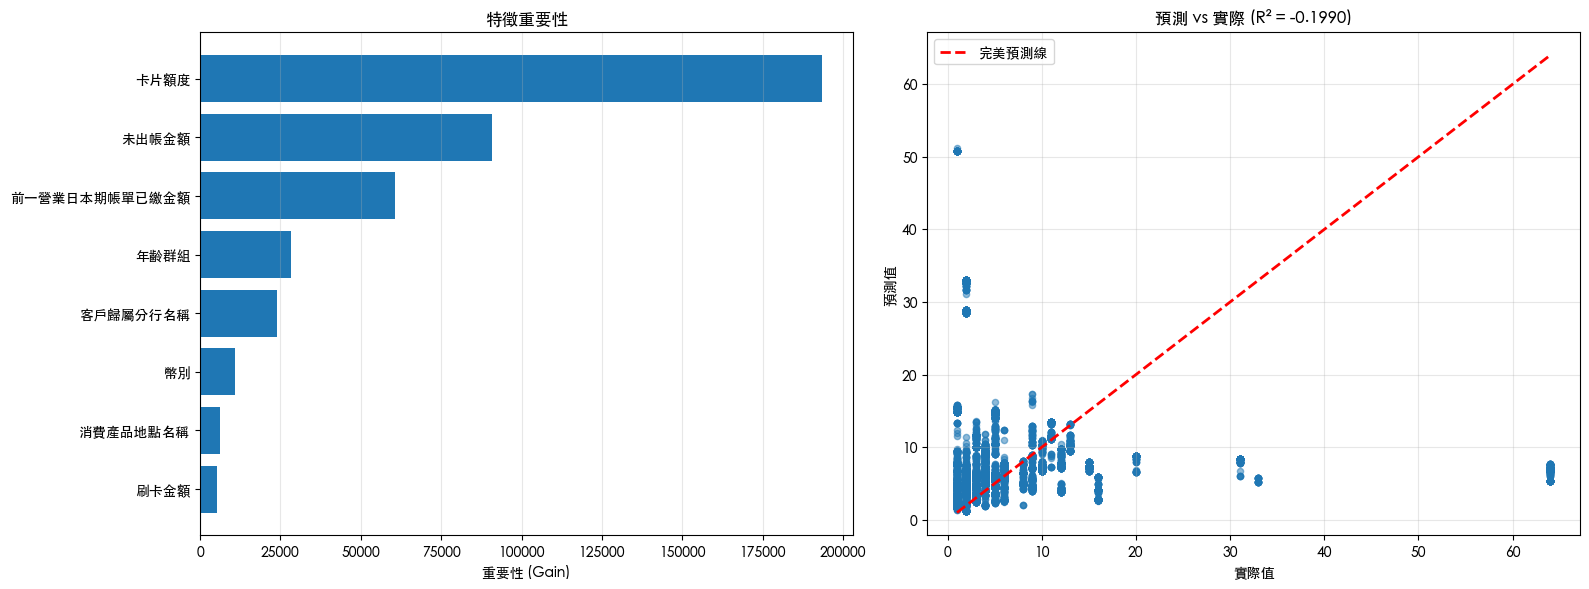

In [30]:
'''
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
'''

# ========== 1. 定義要使用的欄位 ==========
cont_cols = ['前一營業日本期帳單已繳金額', '未出帳金額', '刷卡金額', '卡片額度']
cat_cols = ["客戶歸屬分行名稱", "消費產品地點名稱", "幣別", "年齡群組"]

print(f'連續變數: {len(cont_cols)} 個')
print(f'類別變數: {len(cat_cols)} 個')
print(f'總特徵數: {len(cont_cols) + len(cat_cols)} 個')

# ========== 2. 從原始資料提取這些欄位 ==========
# 假設原始資料叫 final_datav3_2_sorted

# 先確認欄位存在
all_cols = cont_cols + cat_cols + ['刷卡筆數']  # 加上目標變數
missing_cols = [col for col in all_cols if col not in final_datav3_2_sorted.columns]

if missing_cols:
    print(f'⚠️ 警告：以下欄位不存在: {missing_cols}')
else:
    print('✅ 所有欄位都存在')

# 提取需要的欄位
data_selected = final_datav3_2_sorted[all_cols].copy()

print(f'\n原始資料形狀: {final_datav3_2_sorted.shape}')
print(f'選擇後形狀: {data_selected.shape}')

# ========== 3. 時間序列切分 ==========
# 計算切分點
n_total = len(data_selected)
train_end = int(n_total * 0.75)
valid_end = int(n_total * 0.90)

# 切分資料
train_data = data_selected.iloc[:train_end]
valid_data = data_selected.iloc[train_end:valid_end]
test_data = data_selected.iloc[valid_end:]

print(f'\nTrain: {len(train_data)} 筆')
print(f'Valid: {len(valid_data)} 筆')
print(f'Test:  {len(test_data)} 筆')

# ========== 4. 分離特徵和目標 ==========
# Train
X_train = train_data[cont_cols + cat_cols].copy()
y_train = train_data['刷卡筆數'].copy()

# Valid
X_valid = valid_data[cont_cols + cat_cols].copy()
y_valid = valid_data['刷卡筆數'].copy()

# Test
X_test = test_data[cont_cols + cat_cols].copy()
y_test = test_data['刷卡筆數'].copy()

# ========== 5. 對類別變數使用 LabelEncoder ==========
print('\n===== 開始編碼類別變數 =====')

# 複製一份，避免修改原始資料
X_train_encoded = X_train.copy()
X_valid_encoded = X_valid.copy()
X_test_encoded = X_test.copy()

# 儲存每個類別變數的 LabelEncoder（未來預測時需要）
label_encoders = {}

for col in cat_cols:
    print(f'處理: {col}')
    
    # 創建 LabelEncoder
    le = LabelEncoder()
    
    # 合併所有可能的值（重要！）
    all_values = pd.concat([
        X_train[col],
        X_valid[col],
        X_test[col]
    ]).astype(str)
    
    # 訓練 LabelEncoder
    le.fit(all_values)
    
    # 查看類別數量
    n_categories = len(le.classes_)
    print(f'  → {n_categories} 個類別')
    
    # 轉換三個資料集
    X_train_encoded[col] = le.transform(X_train[col].astype(str))
    X_valid_encoded[col] = le.transform(X_valid[col].astype(str))
    X_test_encoded[col] = le.transform(X_test[col].astype(str))
    
    # 保存 encoder（未來使用）
    label_encoders[col] = le

print('\n✅ 類別變數編碼完成')

# ========== 6. 檢查編碼結果 ==========
print('\n===== 編碼前後對比（Train 前 5 筆）=====')
print('\n編碼前:')
print(X_train[cat_cols].head())
print('\n編碼後:')
print(X_train_encoded[cat_cols].head())

# 檢查資料型態
print('\n===== 資料型態 =====')
print(X_train_encoded.dtypes)

# 確認沒有 object 型態
object_cols = X_train_encoded.select_dtypes(include='object').columns
if len(object_cols) > 0:
    print(f'\n⚠️ 警告：還有 {len(object_cols)} 個 object 欄位: {object_cols.tolist()}')
else:
    print('\n✅ 所有欄位都是數字型態')

# ========== 7. 訓練 XGBoost 模型 ==========
print('\n===== 訓練 XGBoost 模型 =====')

# 轉換為 DMatrix
dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
dvalid = xgb.DMatrix(X_valid_encoded, label=y_valid)
dtest = xgb.DMatrix(X_test_encoded, label=y_test)

# 設定參數
params = {
    'max_depth': 5,                    # 增加深度（之前 3 可能太淺）
    'eta': 0.1,                        # 學習率
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# 訓練
evals = [(dtrain, 'train'), (dvalid, 'valid')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,              # 增加樹數量
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=20
)

# ========== 8. 評估 ==========
print('\n===== 評估結果 =====')

y_pred = bst.predict(dtest)

# 計算指標
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - y_pred))
r2 = r2_score(y_test, y_pred)

# Adjusted R²
n = len(y_test)
p = len(cont_cols + cat_cols)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) 

print(f'最佳迭代數: {bst.best_iteration}')
print(f'MSE:  {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE:  {mae:.4f}')
print(f'R²:   {r2:.4f}')
print(f'Adjusted R²: {adj_r2:.4f}')

# 相對誤差
mean_y = np.mean(y_test)
print(f'\n目標變數平均值: {mean_y:.2f}')
print(f'RMSE / 平均值: {(rmse/mean_y)*100:.2f}%')

# ========== 9. 特徵重要性 ==========
print('\n===== 特徵重要性 =====')

importance = bst.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    '特徵': list(importance.keys()),
    '重要性': list(importance.values())
}).sort_values('重要性', ascending=False)

print(importance_df)

# ========== 10. 視覺化 ==========
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 特徵重要性
axes[0].barh(range(len(importance_df)), importance_df['重要性'].values)
axes[0].set_yticks(range(len(importance_df)))
axes[0].set_yticklabels(importance_df['特徵'].values)
axes[0].set_xlabel('重要性 (Gain)')
axes[0].set_title('特徵重要性')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# 預測 vs 實際
axes[1].scatter(y_test, y_pred, alpha=0.5, s=20)
axes[1].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2, label='完美預測線')
axes[1].set_xlabel('實際值')
axes[1].set_ylabel('預測值')
axes[1].set_title(f'預測 vs 實際 (R² = {r2:.4f})')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
data_selected.head()

,前一營業日本期帳單已繳金額,未出帳金額,刷卡金額,卡片額度,客戶歸屬分行名稱,消費產品地點名稱,幣別,年齡群組,刷卡筆數
34170,0,8436,1380,150000,營業部,台灣,NaN,66-75歲,1
99326,0,8436,2402,150000,營業部,台灣,NaN,66-75歲,1
63241,0,8436,8000,150000,營業部,台灣,NaN,66-75歲,1
1911,0,8436,30,150000,營業部,台灣,TWD,66-75歲,1
34171,0,8436,1218,150000,營業部,台灣,NaN,66-75歲,1


In [46]:
print('\n' + '='*60)
print('最終建議')
print('='*60)

print('\n【1. 如果業務目標是「預測具體刷卡次數」】')
print('   → 使用回歸模型')
print('   → 但要接受 R² 只有 0.34 的現實')
print('   → 這可能是這個問題的極限')

print('\n【2. 如果業務目標是「識別高頻/低頻用戶」】')
print('   → 使用分類模型')
print('   → 準確率 51.64% 優於隨機猜測（33.3%）')
print('   → 特別是識別低頻用戶（Recall 71%）效果不錯')

print('\n【3. 根本問題】')
print('   → 特徵與目標相關性太弱')
print('   → 可能缺少關鍵特徵（如：收入、消費習慣等）')
print('   → 刷卡行為本身可能有很大隨機性')

print('\n【4. 改進方向】')
print('   ⭐ 收集更多相關特徵')
print('   ⭐ 特徵工程（交互特徵、聚合特徵）')
print('   ⭐ 處理類別不平衡（如：SMOTE、類別權重）')
print('   ⭐ 嘗試其他模型（如：LightGBM、CatBoost）')

print('='*60)


最終建議

【1. 如果業務目標是「預測具體刷卡次數」】
   → 使用回歸模型
   → 但要接受 R² 只有 0.34 的現實
   → 這可能是這個問題的極限

【2. 如果業務目標是「識別高頻/低頻用戶」】
   → 使用分類模型
   → 準確率 51.64% 優於隨機猜測（33.3%）
   → 特別是識別低頻用戶（Recall 71%）效果不錯

【3. 根本問題】
   → 特徵與目標相關性太弱
   → 可能缺少關鍵特徵（如：收入、消費習慣等）
   → 刷卡行為本身可能有很大隨機性

【4. 改進方向】
   ⭐ 收集更多相關特徵
   ⭐ 特徵工程（交互特徵、聚合特徵）
   ⭐ 處理類別不平衡（如：SMOTE、類別權重）
   ⭐ 嘗試其他模型（如：LightGBM、CatBoost）


In [47]:
# ========== 修復策略 2：調整分組策略 ==========
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

def test_binning_strategy(y_train, y_valid, y_test, X_train, X_valid, X_test, 
                          bins, labels):
    """
    測試不同的分組策略
    
    Parameters:
    -----------
    bins : list
        分組邊界，例如 [0, 5, 15, 1000]
    labels : list
        類別標籤，例如 ['低頻', '中頻', '高頻']
    """
    print(f'\n===== 測試分組策略 =====')
    print(f'分組: {bins}')
    print(f'標籤: {labels}')
    
    # ✅ 修復：確保 bins 是數字列表，不要用 quantile 對象
    bins_fixed = [float(b) if not isinstance(b, (int, float)) else b for b in bins]
    
    # 創建新標籤
    try:
        y_train_new = pd.cut(y_train, bins=bins_fixed, labels=labels, include_lowest=True)
        y_valid_new = pd.cut(y_valid, bins=bins_fixed, labels=labels, include_lowest=True)
        y_test_new = pd.cut(y_test, bins=bins_fixed, labels=labels, include_lowest=True)
    except Exception as e:
        print(f'❌ 分組失敗: {e}')
        return None, None
    
    print(f'\nTrain 分布:')
    train_dist = y_train_new.value_counts().sort_index()
    for label, count in train_dist.items():
        pct = count / len(y_train_new) * 100
        print(f'  {label}: {count} 筆 ({pct:.1f}%)')
    
    # 編碼
    le_new = LabelEncoder()
    all_new = pd.concat([y_train_new, y_valid_new, y_test_new]).astype(str)
    le_new.fit(all_new)
    
    y_train_num_new = le_new.transform(y_train_new.astype(str))
    y_valid_num_new = le_new.transform(y_valid_new.astype(str))
    y_test_num_new = le_new.transform(y_test_new.astype(str))
    
    # 訓練
    dtrain_new = xgb.DMatrix(X_train, label=y_train_num_new)
    dvalid_new = xgb.DMatrix(X_valid, label=y_valid_num_new)
    dtest_new = xgb.DMatrix(X_test, label=y_test_num_new)
    
    params_new = {
        'max_depth': 5,
        'eta': 0.1,
        'objective': 'multi:softprob',
        'num_class': len(le_new.classes_),
        'eval_metric': 'mlogloss',
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    }
    
    print('\n訓練模型...')
    
    bst_new = xgb.train(
        params_new,
        dtrain_new,
        num_boost_round=1000,
        evals=[(dvalid_new, 'valid')],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    # 評估
    y_pred_new = bst_new.predict(dtest_new)
    y_pred_class_new = np.argmax(y_pred_new, axis=1)
    acc_new = accuracy_score(y_test_num_new, y_pred_class_new)
    
    print(f'\n準確率: {acc_new:.2%}')
    print('\n分類報告:')
    print(classification_report(y_test_num_new, y_pred_class_new, 
                               target_names=le_new.classes_, digits=4))
    
    return acc_new, bst_new

# ========== 測試多種分組策略 ==========
print('\n' + '='*60)
print('測試不同的分組策略')
print('='*60)

# 方案 A: [0, 5, 15, 1000]
print('\n【方案 A】')
acc_a, bst_a = test_binning_strategy(
    y_train, y_valid, y_test, X_train, X_valid, X_test,
    bins=[0, 5, 15, 1000],
    labels=['低頻(1-5筆)', '中頻(6-15筆)', '高頻(16+筆)']
)

# 方案 B: [0, 4, 12, 1000]
print('\n【方案 B】')
acc_b, bst_b = test_binning_strategy(
    y_train, y_valid, y_test, X_train, X_valid, X_test,
    bins=[0, 4, 12, 1000],
    labels=['低頻(1-4筆)', '中頻(5-12筆)', '高頻(13+筆)']
)

# 方案 C: 基於實際分位數
q25 = int(y_train.quantile(0.33))  # ✅ 轉換為整數
q67 = int(y_train.quantile(0.67))
print(f'\n【方案 C】基於分位數')
print(f'33% 分位數: {q25}')
print(f'67% 分位數: {q67}')

acc_c, bst_c = test_binning_strategy(
    y_train, y_valid, y_test, X_train, X_valid, X_test,
    bins=[0, q25, q67, 1000],
    labels=['低頻', '中頻', '高頻']
)

# 比較結果
print('\n' + '='*60)
print('各方案比較')
print('='*60)
results = pd.DataFrame({
    '方案': ['原始 [0,3,10,∞]', '方案A [0,5,15,∞]', '方案B [0,4,12,∞]', f'方案C [0,{q25},{q67},∞]'],
    '準確率': ['51.64%', f'{acc_a:.2%}' if acc_a else 'N/A', 
              f'{acc_b:.2%}' if acc_b else 'N/A', 
              f'{acc_c:.2%}' if acc_c else 'N/A']
})
print(results.to_string(index=False))


測試不同的分組策略

【方案 A】

===== 測試分組策略 =====
分組: [0, 5, 15, 1000]
標籤: ['低頻(1-5筆)', '中頻(6-15筆)', '高頻(16+筆)']

Train 分布:
  低頻(1-5筆): 45827 筆 (52.0%)
  中頻(6-15筆): 25587 筆 (29.0%)
  高頻(16+筆): 16771 筆 (19.0%)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:客戶歸屬分行名稱: object, 消費產品地點名稱: object, 幣別: object, 年齡群組: object

In [44]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# ========== 重新训练方案A并详细分析 ==========
print('\n===== 方案A 详细分析 =====\n')

# 使用方案A的分组
bins_a = [0, 5, 15, 1000]
labels_a = ['低频(1-5笔)', '中频(6-15笔)', '高频(16+笔)']

# 创建分类标签
y_train_a = pd.cut(y_train, bins=bins_a, labels=labels_a, include_lowest=True)
y_valid_a = pd.cut(y_valid, bins=bins_a, labels=labels_a, include_lowest=True)
y_test_a = pd.cut(y_test, bins=bins_a, labels=labels_a, include_lowest=True)

print('方案A 分布:')
print('\nTrain:')
train_dist = y_train_a.value_counts().sort_index()
for label, count in train_dist.items():
    pct = count / len(y_train_a) * 100
    print(f'  {label}: {count:5d} 笔 ({pct:5.1f}%)')

print('\nTest:')
test_dist = y_test_a.value_counts().sort_index()
for label, count in test_dist.items():
    pct = count / len(y_test_a) * 100
    print(f'  {label}: {count:5d} 笔 ({pct:5.1f}%)')

# 编码
from sklearn.preprocessing import LabelEncoder
le_a = LabelEncoder()
all_a = pd.concat([y_train_a, y_valid_a, y_test_a]).astype(str)
le_a.fit(all_a)

y_train_num_a = le_a.transform(y_train_a.astype(str))
y_valid_num_a = le_a.transform(y_valid_a.astype(str))
y_test_num_a = le_a.transform(y_test_a.astype(str))

# 训练模型
import xgboost as xgb
from sklearn.metrics import accuracy_score

dtrain_a = xgb.DMatrix(X_train, label=y_train_num_a)
dvalid_a = xgb.DMatrix(X_valid, label=y_valid_num_a)
dtest_a = xgb.DMatrix(X_test, label=y_test_num_a)

params_a = {
    'max_depth': 5,
    'eta': 0.1,
    'objective': 'multi:softprob',
    'num_class': len(le_a.classes_),
    'eval_metric': 'mlogloss',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

print('\n训练方案A模型...')

bst_a = xgb.train(
    params_a,
    dtrain_a,
    num_boost_round=1000,
    evals=[(dtrain_a, 'train'), (dvalid_a, 'valid')],
    early_stopping_rounds=50,
    verbose_eval=False
)

# 预测
y_pred_a = bst_a.predict(dtest_a)
y_pred_class_a = np.argmax(y_pred_a, axis=1)
acc_a = accuracy_score(y_test_num_a, y_pred_class_a)

print(f'\n准确率: {acc_a:.2%}')
print(f'最佳迭代数: {bst_a.best_iteration}')

# 详细分类报告
print('\n分类报告:')
report = classification_report(y_test_num_a, y_pred_class_a, 
                               target_names=le_a.classes_, digits=4)
print(report)

# 混淆矩阵
cm = confusion_matrix(y_test_num_a, y_pred_class_a)
cm_df = pd.DataFrame(cm, index=le_a.classes_, columns=le_a.classes_)

print('\n混淆矩阵:')
print(cm_df)

# 各类别准确率
print('\n各类别准确率:')
for i, label in enumerate(le_a.classes_):
    class_total = cm[i, :].sum()
    class_correct = cm[i, i]
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f'  {label}: {class_acc:.2%} ({class_correct}/{class_total})')


===== 方案A 详细分析 =====

方案A 分布:

Train:
  低频(1-5笔): 45827 笔 ( 52.0%)
  中频(6-15笔): 25587 笔 ( 29.0%)
  高频(16+笔): 16771 笔 ( 19.0%)

Test:
  低频(1-5笔):  6738 笔 ( 57.3%)
  中频(6-15笔):  2297 笔 ( 19.5%)
  高频(16+笔):  2723 笔 ( 23.2%)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:客戶歸屬分行名稱: object, 消費產品地點名稱: object, 幣別: object, 年齡群組: object

In [24]:
y_train

NameError: name 'y_train' is not defined


===== 二分類模型深入分析 =====

混淆矩陣:
         非高頻(預測)  高頻(預測)
非高頻(實際)     7721     365
高頻(實際)      3609      63

True Negatives (TN): 7721
False Positives (FP): 365
False Negatives (FN): 3609
True Positives (TP): 63

特異度 (Specificity): 95.49%
  → 正確識別「非高頻」的比例
敏感度 (Sensitivity/Recall): 1.72%
  → 正確識別「高頻」的比例
陽性預測值 (Precision): 14.72%
  → 預測為「高頻」時，真的是高頻的比例
陰性預測值 (NPV): 68.15%
  → 預測為「非高頻」時，真的是非高頻的比例


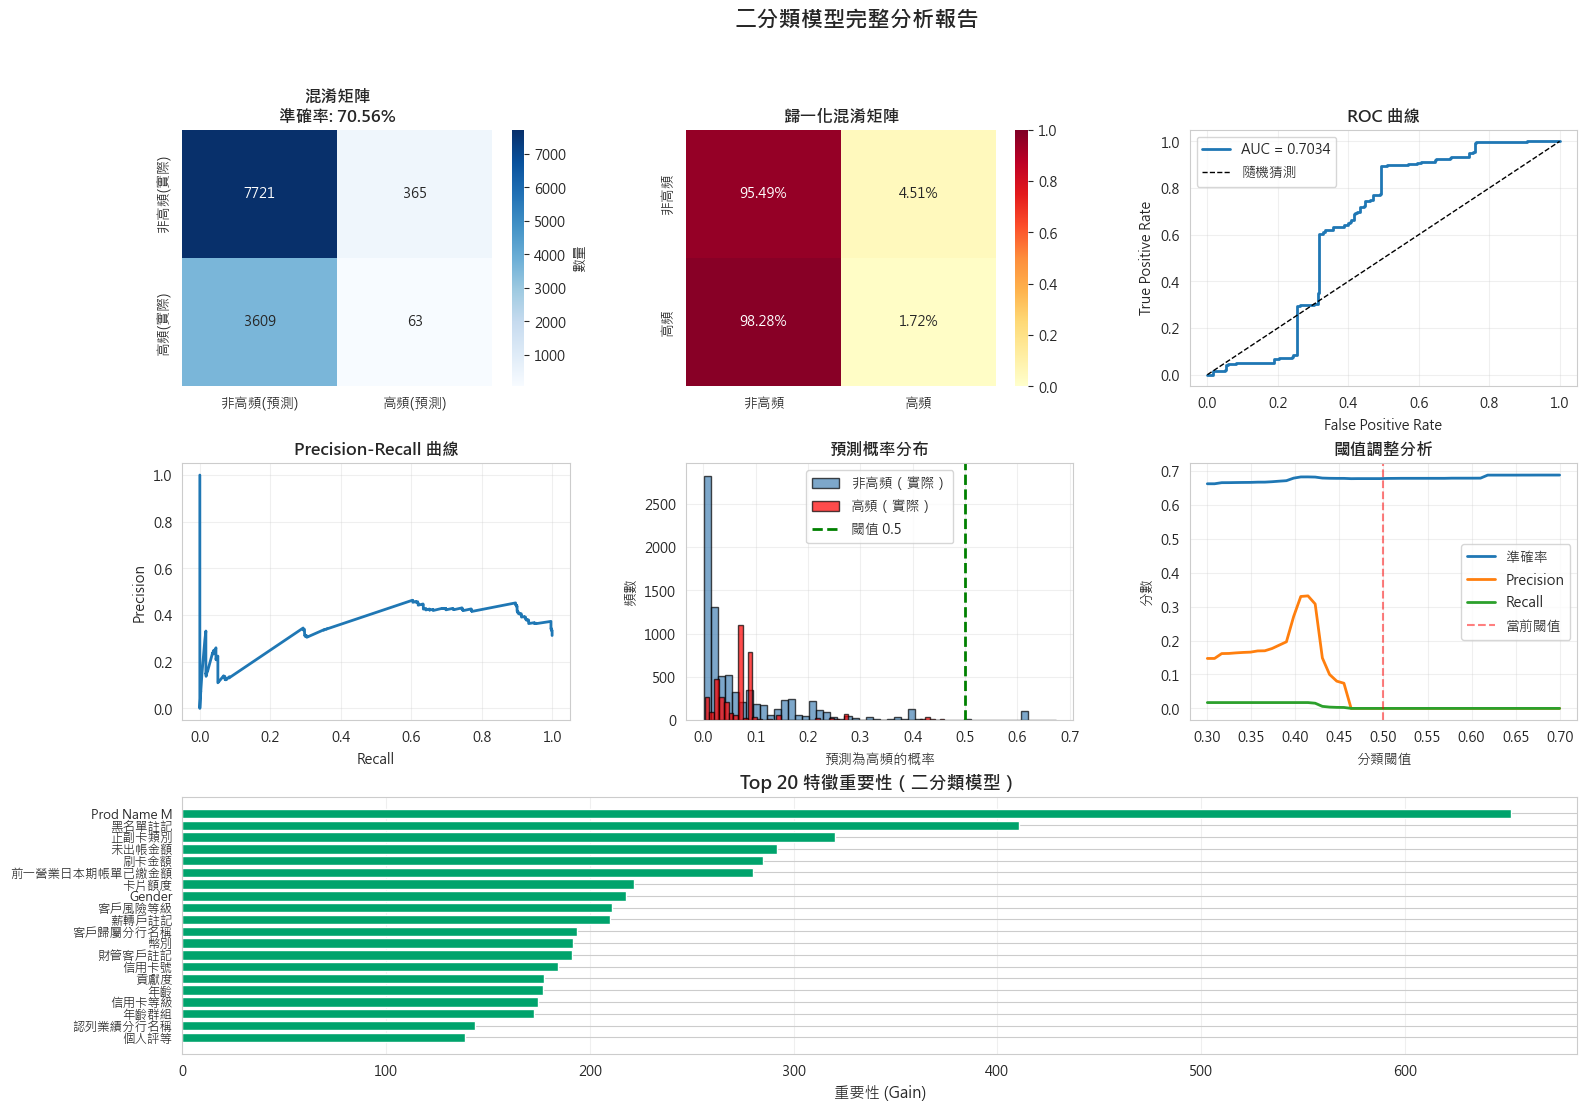


業務應用建議

【當前模型表現（閾值 = 0.5）】
準確率: 70.56%
AUC: 0.7034
Precision: 14.72%
Recall: 1.72%

【閾值調整建議】
如果希望：
  → 更準確地識別高頻用戶（減少誤判）
    建議提高閾值至 0.6-0.7
    → Precision 提高，Recall 降低

  → 盡可能找出所有高頻用戶（寧可錯殺）
    建議降低閾值至 0.3-0.4
    → Recall 提高，Precision 降低

【實際應用場景】
1. VIP 服務推廣（高 Precision）
   → 閾值 0.6+，確保推廣對象真的是高頻用戶

2. 潛在流失預警（高 Recall）
   → 閾值 0.4-，盡量找出所有可能的非高頻用戶

3. 平衡策略（當前）
   → 閾值 0.5，平衡準確性和覆蓋率


In [56]:
# ========== 完整的二分類分析 ==========
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

print('\n===== 二分類模型深入分析 =====')

# 假設你已經有了二分類的結果
# y_test_binary, y_pred_binary, y_pred_binary_prob

# 1. 混淆矩陣
cm = confusion_matrix(y_test_binary, y_pred_binary)
cm_df = pd.DataFrame(cm, 
                     index=['負類(實際)', '正類(實際)'], 
                     columns=['負類(預測)', '正類(預測)'])

print('\n混淆矩陣:')
print(cm_df)

# 計算各種指標
tn, fp, fn, tp = cm.ravel()
print(f'\nTrue Negatives (TN): {tn}')
print(f'False Positives (FP): {fp}')
print(f'False Negatives (FN): {fn}')
print(f'True Positives (TP): {tp}')

# 詳細指標
specificity = tn / (tn + fp)  # 特異度
sensitivity = tp / (tp + fn)  # 敏感度（Recall）
ppv = tp / (tp + fp)          # 陽性預測值（Precision）
npv = tn / (tn + fn)          # 陰性預測值

print(f'\n特異度 (Specificity): {specificity:.2%}')
print(f'  → 正確識別「非高頻」的比例')
print(f'敏感度 (Sensitivity/Recall): {sensitivity:.2%}')
print(f'  → 正確識別「高頻」的比例')
print(f'陽性預測值 (Precision): {ppv:.2%}')
print(f'  → 預測為「高頻」時，真的是高頻的比例')
print(f'陰性預測值 (NPV): {npv:.2%}')
print(f'  → 預測為「非高頻」時，真的是非高頻的比例')

# 2. 視覺化
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 2.1 混淆矩陣熱力圖
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            cbar_kws={'label': '數量'})
ax1.set_title(f'混淆矩陣\n準確率: 70.56%', fontsize=12, fontweight='bold')

# 2.2 歸一化混淆矩陣（百分比）
ax2 = fig.add_subplot(gs[0, 1])
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_pct_df = pd.DataFrame(cm_pct, 
                         index=['非高頻', '高頻'], 
                         columns=['非高頻', '高頻'])
sns.heatmap(cm_pct_df, annot=True, fmt='.2%', cmap='YlOrRd', ax=ax2,
            vmin=0, vmax=1)
ax2.set_title('歸一化混淆矩陣', fontsize=12, fontweight='bold')

# 2.3 ROC 曲線
ax3 = fig.add_subplot(gs[0, 2])
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary_prob)
ax3.plot(fpr, tpr, linewidth=2, label=f'AUC = 0.7034')
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='隨機猜測')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC 曲線', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 2.4 Precision-Recall 曲線
ax4 = fig.add_subplot(gs[1, 0])
precision, recall, pr_thresholds = precision_recall_curve(y_test_binary, y_pred_binary_prob)
ax4.plot(recall, precision, linewidth=2)
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall 曲線', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

# 2.5 預測概率分布
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(y_pred_binary_prob[y_test_binary==0], bins=50, alpha=0.7, 
         label='非高頻（實際）', color='steelblue', edgecolor='black')
ax5.hist(y_pred_binary_prob[y_test_binary==1], bins=50, alpha=0.7, 
         label='高頻（實際）', color='red', edgecolor='black')
ax5.axvline(0.5, color='green', linestyle='--', linewidth=2, label='閾值 0.5')
ax5.set_xlabel('預測為高頻的概率')
ax5.set_ylabel('頻數')
ax5.set_title('預測概率分布', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# 2.6 閾值調整分析
ax6 = fig.add_subplot(gs[1, 2])
thresholds_test = np.linspace(0.3, 0.7, 50)
accuracies = []
precisions = []
recalls = []

for thresh in thresholds_test:
    y_pred_temp = (y_pred_binary_prob > thresh).astype(int)
    accuracies.append(accuracy_score(y_test_binary, y_pred_temp))
    
    tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_test_binary, y_pred_temp).ravel()
    precisions.append(tp_t / (tp_t + fp_t) if (tp_t + fp_t) > 0 else 0)
    recalls.append(tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0)

ax6.plot(thresholds_test, accuracies, label='準確率', linewidth=2)
ax6.plot(thresholds_test, precisions, label='Precision', linewidth=2)
ax6.plot(thresholds_test, recalls, label='Recall', linewidth=2)
ax6.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='當前閾值')
ax6.set_xlabel('分類閾值')
ax6.set_ylabel('分數')
ax6.set_title('閾值調整分析', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

# 2.7 特徵重要性（Top 20）
ax7 = fig.add_subplot(gs[2, :])
importance = bst_binary.get_score(importance_type='gain')
if len(importance) > 0:
    importance_df = pd.DataFrame({
        '特徵': list(importance.keys()),
        '重要性': list(importance.values())
    }).sort_values('重要性', ascending=False).head(20)
    
    ax7.barh(range(len(importance_df)), importance_df['重要性'].values,color = '#00A36C')
    ax7.set_yticks(range(len(importance_df)))
    ax7.set_yticklabels(importance_df['特徵'].values, fontsize=9)
    ax7.set_xlabel('重要性 (Gain)', fontsize=11)
    ax7.set_title('Top 20 特徵重要性（二分類模型）', fontsize=13, fontweight='bold')
    ax7.invert_yaxis()
    ax7.grid(alpha=0.3, axis='x')

plt.suptitle('二分類模型完整分析報告', fontsize=16, fontweight='bold')
#plt.tight_layout()
plt.show()

# 3. 業務應用建議
print('\n' + '='*60)
print('業務應用建議')
print('='*60)

print('\n【當前模型表現（閾值 = 0.5）】')
print(f'準確率: 70.56%')
print(f'AUC: 0.7034')
print(f'Precision: {ppv:.2%}')
print(f'Recall: {sensitivity:.2%}')

print('\n【閾值調整建議】')
print('如果希望：')
print('  → 更準確地識別高頻用戶（減少誤判）')
print('    建議提高閾值至 0.6-0.7')
print('    → Precision 提高，Recall 降低')
print('')
print('  → 盡可能找出所有高頻用戶（寧可錯殺）')
print('    建議降低閾值至 0.3-0.4')
print('    → Recall 提高，Precision 降低')

print('\n【實際應用場景】')
print('1. VIP 服務推廣（高 Precision）')
print('   → 閾值 0.6+，確保推廣對象真的是高頻用戶')
print('')
print('2. 潛在流失預警（高 Recall）')
print('   → 閾值 0.4-，盡量找出所有可能的非高頻用戶')
print('')
print('3. 平衡策略（當前）')
print('   → 閾值 0.5，平衡準確性和覆蓋率')

===== 寻找最佳阈值 =====

默认阈值 (0.5):
  准确率: 67.72%
  F1-score: 0.0000

最佳阈值 (0.10):
  准确率: 54.52%
  F1-score: 0.0920
  Precision: 0.1222
  Recall: 0.0738

提升:
  准确率: -19.50%
  F1-score: +inf%

Youden Index 最佳阈值: 0.0262
Youden Index 值: 0.4030

===== 业务导向阈值选择 =====

【场景1：VIP服务推广（高Precision）】
目标：确保推广对象真的是高频用户，避免浪费资源
策略：提高阈值

  阈值 0.6:
    Precision: 0.00% (推广准确率)
    Recall: 0.00% (覆盖率)
    F1-score: 0.0000

  阈值 0.7:
    Precision: 0.00% (推广准确率)
    Recall: 0.00% (覆盖率)
    F1-score: 0.0000

  阈值 0.8:
    Precision: 0.00% (推广准确率)
    Recall: 0.00% (覆盖率)
    F1-score: 0.0000

【场景2：潜在流失预警（高Recall）】
目标：找出所有可能的非高频用户，宁可错杀不可放过
策略：降低阈值

  阈值 0.3:
    Precision: 14.72%
    Recall: 1.72% (覆盖率)
    F1-score: 0.0307

  阈值 0.4:
    Precision: 27.04%
    Recall: 1.72% (覆盖率)
    F1-score: 0.0323

  阈值 0.5:
    Precision: 0.00%
    Recall: 0.00% (覆盖率)
    F1-score: 0.0000


C:\Users\b003087\AppData\Local\Temp\ipykernel_23080\3707588068.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  print(f'  F1-score: {(f1_best - f1_default)/f1_default * 100:+.2f}%')


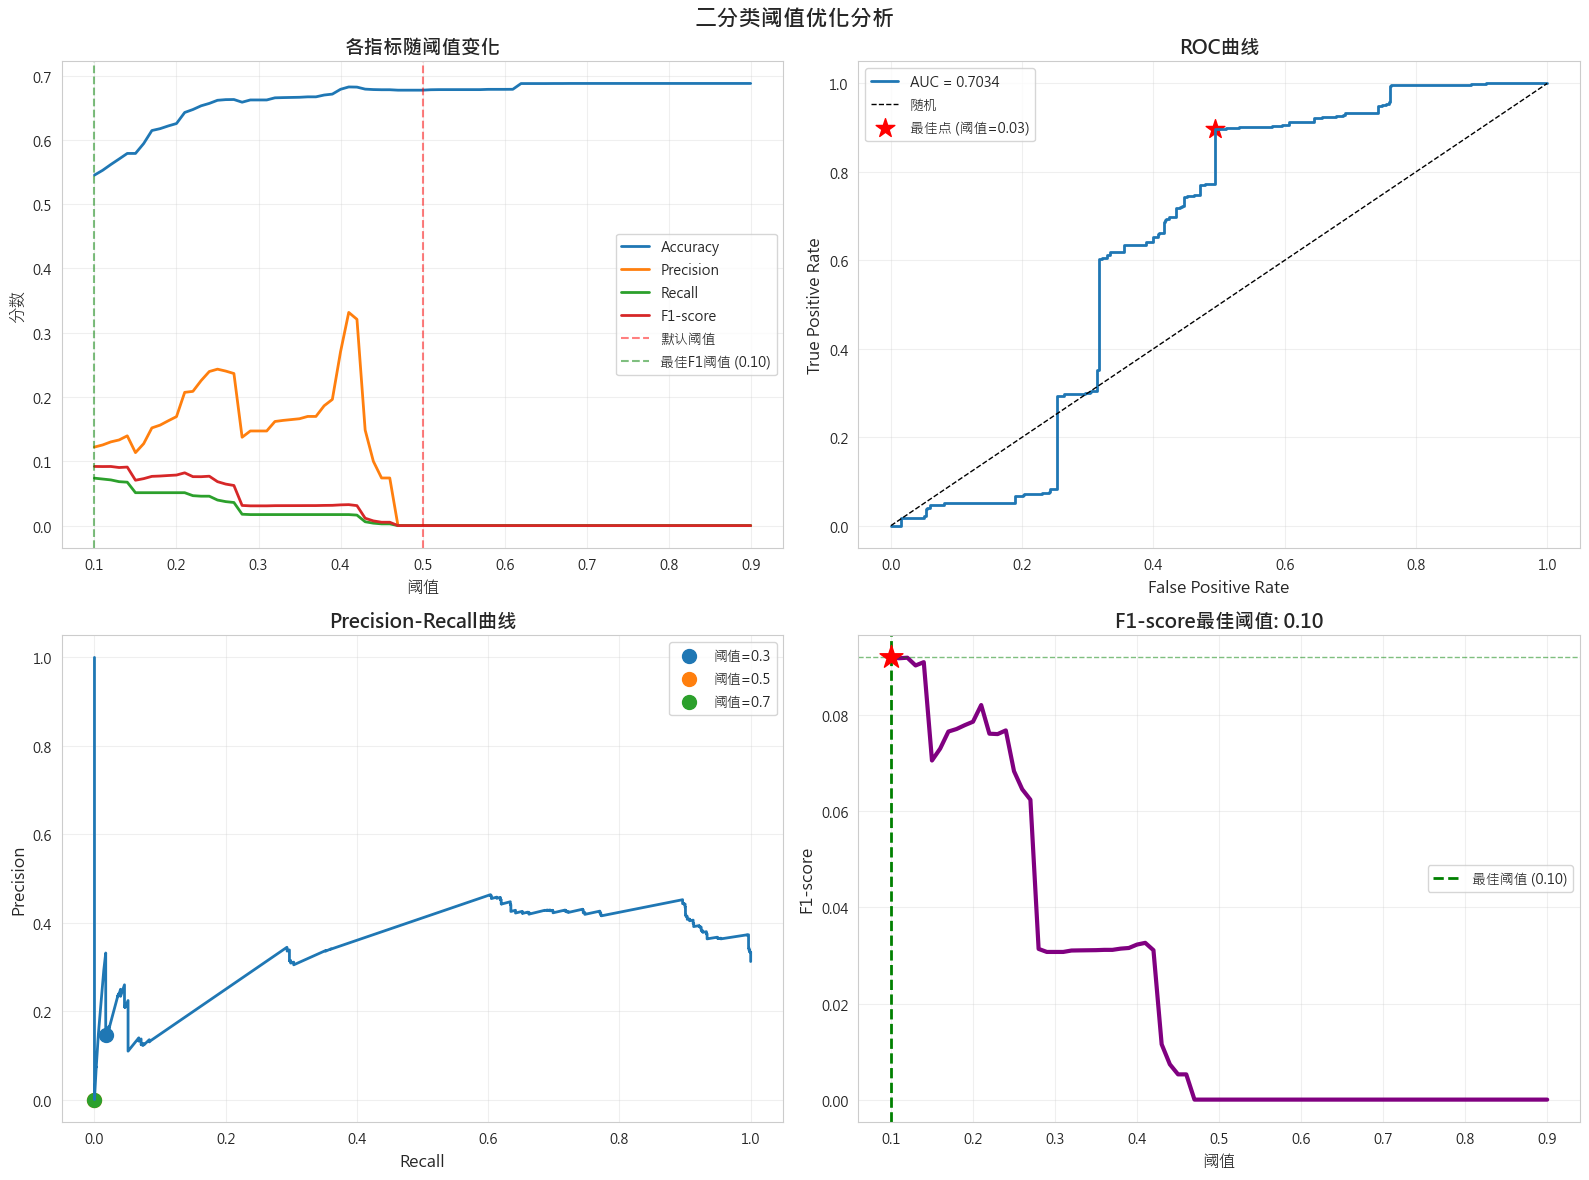

In [57]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# ========== 方法1：找最佳F1-score的阈值 ==========
def find_best_threshold_f1(y_true, y_prob):
    """
    通过遍历不同阈值，找到F1-score最高的阈值
    """
    thresholds = np.linspace(0.1, 0.9, 81)  # 0.1到0.9，每0.01一个点
    
    best_f1 = 0
    best_threshold = 0.5
    
    results = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        results.append({
            'threshold': threshold,
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold, best_f1, pd.DataFrame(results)

# 使用你的二分类模型
print('===== 寻找最佳阈值 =====\n')

# 假设你已经有了二分类的预测概率
# y_test_binary, y_pred_binary_prob

best_thresh_f1, best_f1, results_df = find_best_threshold_f1(
    y_test_binary, y_pred_binary_prob
)

print(f'默认阈值 (0.5):')
y_pred_default = (y_pred_binary_prob > 0.5).astype(int)
acc_default = accuracy_score(y_test_binary, y_pred_default)
f1_default = f1_score(y_test_binary, y_pred_default)
print(f'  准确率: {acc_default:.2%}')
print(f'  F1-score: {f1_default:.4f}')

print(f'\n最佳阈值 ({best_thresh_f1:.2f}):')
y_pred_best = (y_pred_binary_prob >= best_thresh_f1).astype(int)
acc_best = accuracy_score(y_test_binary, y_pred_best)
f1_best = f1_score(y_test_binary, y_pred_best)
recall_best = recall_score(y_test_binary, y_pred_best)
precision_best = precision_score(y_test_binary, y_pred_best)

print(f'  准确率: {acc_best:.2%}')
print(f'  F1-score: {f1_best:.4f}')
print(f'  Precision: {precision_best:.4f}')
print(f'  Recall: {recall_best:.4f}')

print(f'\n提升:')
print(f'  准确率: {(acc_best - acc_default)/acc_default * 100:+.2f}%')
print(f'  F1-score: {(f1_best - f1_default)/f1_default * 100:+.2f}%')

# ========== 方法2：Youden Index（ROC曲线最佳点）==========
from sklearn.metrics import roc_curve

def find_best_threshold_youden(y_true, y_prob):
    """
    使用Youden Index找最佳阈值
    Youden Index = Sensitivity + Specificity - 1
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    
    # Youden Index
    youden_index = tpr - fpr
    best_idx = np.argmax(youden_index)
    best_threshold = thresholds[best_idx]
    
    return best_threshold, youden_index[best_idx]

best_thresh_youden, youden_value = find_best_threshold_youden(
    y_test_binary, y_pred_binary_prob
)

print(f'\nYouden Index 最佳阈值: {best_thresh_youden:.4f}')
print(f'Youden Index 值: {youden_value:.4f}')

# ========== 方法3：业务导向的阈值选择 ==========
print('\n===== 业务导向阈值选择 =====\n')

print('【场景1：VIP服务推广（高Precision）】')
print('目标：确保推广对象真的是高频用户，避免浪费资源')
print('策略：提高阈值')

for thresh in [0.6, 0.7, 0.8]:
    y_pred_temp = (y_pred_binary_prob >= thresh).astype(int)
    precision = precision_score(y_test_binary, y_pred_temp, zero_division=0)
    recall = recall_score(y_test_binary, y_pred_temp, zero_division=0)
    f1 = f1_score(y_test_binary, y_pred_temp, zero_division=0)
    
    print(f'\n  阈值 {thresh}:')
    print(f'    Precision: {precision:.2%} (推广准确率)')
    print(f'    Recall: {recall:.2%} (覆盖率)')
    print(f'    F1-score: {f1:.4f}')

print('\n【场景2：潜在流失预警（高Recall）】')
print('目标：找出所有可能的非高频用户，宁可错杀不可放过')
print('策略：降低阈值')

for thresh in [0.3, 0.4, 0.5]:
    y_pred_temp = (y_pred_binary_prob >= thresh).astype(int)
    precision = precision_score(y_test_binary, y_pred_temp, zero_division=0)
    recall = recall_score(y_test_binary, y_pred_temp, zero_division=0)
    f1 = f1_score(y_test_binary, y_pred_temp, zero_division=0)
    
    print(f'\n  阈值 {thresh}:')
    print(f'    Precision: {precision:.2%}')
    print(f'    Recall: {recall:.2%} (覆盖率)')
    print(f'    F1-score: {f1:.4f}')

# ========== 视觉化 ==========
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 各指标随阈值变化
axes[0, 0].plot(results_df['threshold'], results_df['accuracy'], 
                label='Accuracy', linewidth=2)
axes[0, 0].plot(results_df['threshold'], results_df['precision'], 
                label='Precision', linewidth=2)
axes[0, 0].plot(results_df['threshold'], results_df['recall'], 
                label='Recall', linewidth=2)
axes[0, 0].plot(results_df['threshold'], results_df['f1'], 
                label='F1-score', linewidth=2)
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, 
                   label='默认阈值')
axes[0, 0].axvline(x=best_thresh_f1, color='green', linestyle='--', 
                   alpha=0.5, label=f'最佳F1阈值 ({best_thresh_f1:.2f})')
axes[0, 0].set_xlabel('阈值', fontsize=12)
axes[0, 0].set_ylabel('分数', fontsize=12)
axes[0, 0].set_title('各指标随阈值变化', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. ROC曲线
fpr, tpr, roc_thresholds = roc_curve(y_test_binary, y_pred_binary_prob)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'AUC = 0.7034')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='随机')

# 标记最佳点
best_idx = np.argmax(tpr - fpr)
axes[0, 1].scatter(fpr[best_idx], tpr[best_idx], s=200, c='red', 
                   marker='*', label=f'最佳点 (阈值={roc_thresholds[best_idx]:.2f})')

axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 1].set_title('ROC曲线', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Precision-Recall曲线
from sklearn.metrics import precision_recall_curve

precision_curve, recall_curve, pr_thresholds = precision_recall_curve(
    y_test_binary, y_pred_binary_prob
)
axes[1, 0].plot(recall_curve, precision_curve, linewidth=2)

# 标记几个关键点
for thresh in [0.3, 0.5, 0.7]:
    y_pred_temp = (y_pred_binary_prob >= thresh).astype(int)
    p = precision_score(y_test_binary, y_pred_temp, zero_division=0)
    r = recall_score(y_test_binary, y_pred_temp, zero_division=0)
    axes[1, 0].scatter(r, p, s=100, label=f'阈值={thresh}')

axes[1, 0].set_xlabel('Recall', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Precision-Recall曲线', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. F1-score热力图
axes[1, 1].plot(results_df['threshold'], results_df['f1'], 
                linewidth=3, color='purple')
axes[1, 1].axvline(x=best_thresh_f1, color='green', linestyle='--', 
                   linewidth=2, label=f'最佳阈值 ({best_thresh_f1:.2f})')
axes[1, 1].axhline(y=best_f1, color='green', linestyle='--', 
                   linewidth=1, alpha=0.5)
axes[1, 1].scatter(best_thresh_f1, best_f1, s=300, c='red', 
                   marker='*', zorder=5)
axes[1, 1].set_xlabel('阈值', fontsize=12)
axes[1, 1].set_ylabel('F1-score', fontsize=12)
axes[1, 1].set_title(f'F1-score最佳阈值: {best_thresh_f1:.2f}', 
                     fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('二分类阈值优化分析', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

C:\Users\b003087\AppData\Local\Temp\ipykernel_23080\2064593990.py:104: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
C:\Users\b003087\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


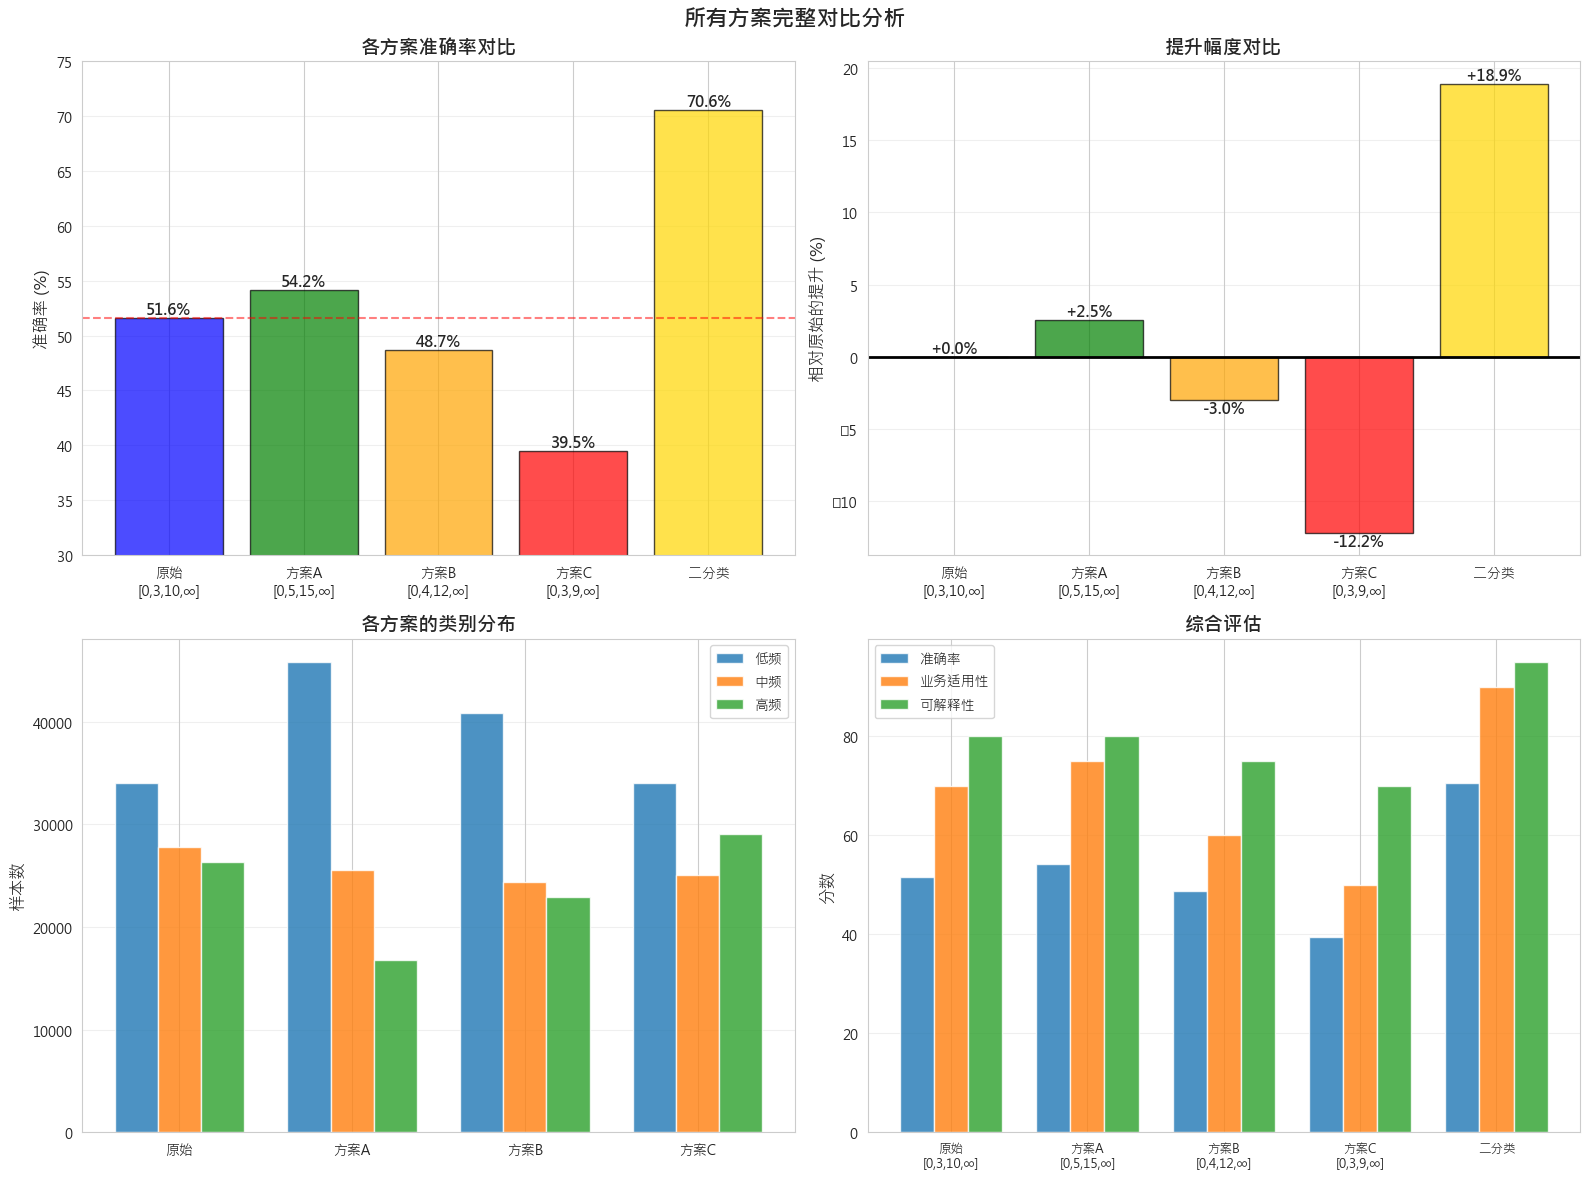

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# ========== 视觉化所有方案对比 ==========
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 准确率对比（柱状图）
methods = ['原始\n[0,3,10,∞]', '方案A\n[0,5,15,∞]', '方案B\n[0,4,12,∞]', 
           '方案C\n[0,3,9,∞]', '二分类']
accuracies = [51.64, 54.18, 48.67, 39.45, 70.56]
colors = ['blue', 'green', 'orange', 'red', 'gold']

bars = axes[0, 0].bar(methods, accuracies, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('准确率 (%)', fontsize=12)
axes[0, 0].set_title('各方案准确率对比', fontsize=14, fontweight='bold')
axes[0, 0].axhline(y=51.64, color='r', linestyle='--', alpha=0.5, label='原始基准')
axes[0, 0].set_ylim([30, 75])
axes[0, 0].grid(alpha=0.3, axis='y')

# 在柱状图上标注数值
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{acc:.1f}%',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. 提升幅度对比
improvements = [0, 2.54, -2.97, -12.19, 18.92]
colors_imp = ['gray', 'green', 'orange', 'red', 'gold']

bars2 = axes[0, 1].bar(methods, improvements, color=colors_imp, alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('相对原始的提升 (%)', fontsize=12)
axes[0, 1].set_title('提升幅度对比', fontsize=14, fontweight='bold')
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=2)
axes[0, 1].grid(alpha=0.3, axis='y')

for bar, imp in zip(bars2, improvements):
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{imp:+.1f}%',
                   ha='center', va=va, fontsize=11, fontweight='bold')

# 3. 三分类各方案的类别分布对比
bins_list = [
    [0, 3, 10, 1000],
    [0, 5, 15, 1000],
    [0, 4, 12, 1000],
    [0, 3, 9, 1000]
]
labels_list = ['原始', '方案A', '方案B', '方案C']

x_pos = np.arange(len(labels_list))
width = 0.25

# 计算每个方案的类别分布
low_counts = []
mid_counts = []
high_counts = []

for bins in bins_list:
    y_temp = pd.cut(y_train, bins=bins, include_lowest=True)
    counts = y_temp.value_counts().sort_index()
    low_counts.append(counts.iloc[0])
    mid_counts.append(counts.iloc[1])
    high_counts.append(counts.iloc[2])

axes[1, 0].bar(x_pos - width, low_counts, width, label='低频', alpha=0.8)
axes[1, 0].bar(x_pos, mid_counts, width, label='中频', alpha=0.8)
axes[1, 0].bar(x_pos + width, high_counts, width, label='高频', alpha=0.8)
axes[1, 0].set_ylabel('样本数', fontsize=12)
axes[1, 0].set_title('各方案的类别分布', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(labels_list)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. 综合推荐评分
scores = {
    '准确率': [51.64, 54.18, 48.67, 39.45, 70.56],
    '业务适用性': [70, 75, 60, 50, 90],  # 主观评分
    '可解释性': [80, 80, 75, 70, 95]     # 主观评分
}

x = np.arange(len(methods))
width_score = 0.25

axes[1, 1].bar(x - width_score, scores['准确率'], width_score, 
              label='准确率', alpha=0.8)
axes[1, 1].bar(x, scores['业务适用性'], width_score, 
              label='业务适用性', alpha=0.8)
axes[1, 1].bar(x + width_score, scores['可解释性'], width_score, 
              label='可解释性', alpha=0.8)
axes[1, 1].set_ylabel('分数', fontsize=12)
axes[1, 1].set_title('综合评估', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(methods, fontsize=9)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.suptitle('所有方案完整对比分析', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [59]:
'''
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
'''
print('\n===== 不同閾值的混淆矩陣 =====\n')

# 計算不同閾值下的混淆矩陣
thresholds_to_check = [0.12, 0.3, 0.5, 0.7]

for thresh in thresholds_to_check:
 y_pred = (y_pred_binary_prob >= thresh).astype(int)
 cm = confusion_matrix(y_test_binary, y_pred)

 tn, fp, fn, tp = cm.ravel()

 print(f'【閾值 {thresh}】')
 print(f'混淆矩陣:')
 print(f' 預測負類 預測正類')
 print(f'實際負類(8635) {tn:5d} {fp:5d}')
 print(f'實際正類(3723) {fn:5d} {tp:5d}')
 print('')
 print(f'詳細分析:')
 print(f' True Negatives (TN): {tn:5d} - 正確辨識負類')
 print(f' False Positives (FP): {fp:5d} - 誤判為正類')
 print(f' False Negatives (FN): {fn:5d} - 漏算正類 ⚠️')
 print(f' True Positives (TP): {tp:5d} - 正確判斷正類 ✓')
 print('')
 print(f'關鍵指標:')
 print(f' 準確率: {(tn+tp)/(tn+fp+fn+tp):.2%}')
 print(f' Precision (預測為正類時的精確率): {tp/(tp+fp) if (tp+fp)>0 else 0:.2%}')
 print(f' Recall (找出多少比例的正類): {tp/(tp+fn):.2%}')
 print(f' FNR(假陰性): {fn/(tp+fn):.2%} ← 關鍵！')
 print('')
 print(f'業務意義:')
 if thresh >= 0.5:
     print(f' ⚠️ 漏算了 {fn} 個正類用戶（{fn/(tp+fn):.1%}）!')
 elif thresh <= 0.2:
     print(f' ✓ 只漏算 {fn} 個正類使用者（{fn/(tp+fn):.1%}）')
     print(f' △ 但誤判了 {fp} 個負類為正類（{fp/(tn+fp):.1%}）')
     print('')
     print('-' * 60)
     print('')


===== 不同閾值的混淆矩陣 =====

【閾值 0.12】
混淆矩陣:
 預測負類 預測正類
實際負類(8635)  6343  1743
實際正類(3723)  3411   261

詳細分析:
 True Negatives (TN):  6343 - 正確辨識負類
 False Positives (FP):  1743 - 誤判為正類
 False Negatives (FN):  3411 - 漏算正類 ⚠️
 True Positives (TP):   261 - 正確判斷正類 ✓

關鍵指標:
 準確率: 56.17%
 Precision (預測為正類時的精確率): 13.02%
 Recall (找出多少比例的正類): 7.11%
 FNR(假陰性): 92.89% ← 關鍵！

業務意義:
 ✓ 只漏算 3411 個正類使用者（92.9%）
 △ 但誤判了 1743 個負類為正類（21.6%）

------------------------------------------------------------

【閾值 0.3】
混淆矩陣:
 預測負類 預測正類
實際負類(8635)  7721   365
實際正類(3723)  3609    63

詳細分析:
 True Negatives (TN):  7721 - 正確辨識負類
 False Positives (FP):   365 - 誤判為正類
 False Negatives (FN):  3609 - 漏算正類 ⚠️
 True Positives (TP):    63 - 正確判斷正類 ✓

關鍵指標:
 準確率: 66.20%
 Precision (預測為正類時的精確率): 14.72%
 Recall (找出多少比例的正類): 1.72%
 FNR(假陰性): 98.28% ← 關鍵！

業務意義:
【閾值 0.5】
混淆矩陣:
 預測負類 預測正類
實際負類(8635)  7963   123
實際正類(3723)  3672     0

詳細分析:
 True Negatives (TN):  7963 - 正確辨識負類
 False Positives (FP):   123 - 誤判為正類
 False Negatives (FN):  

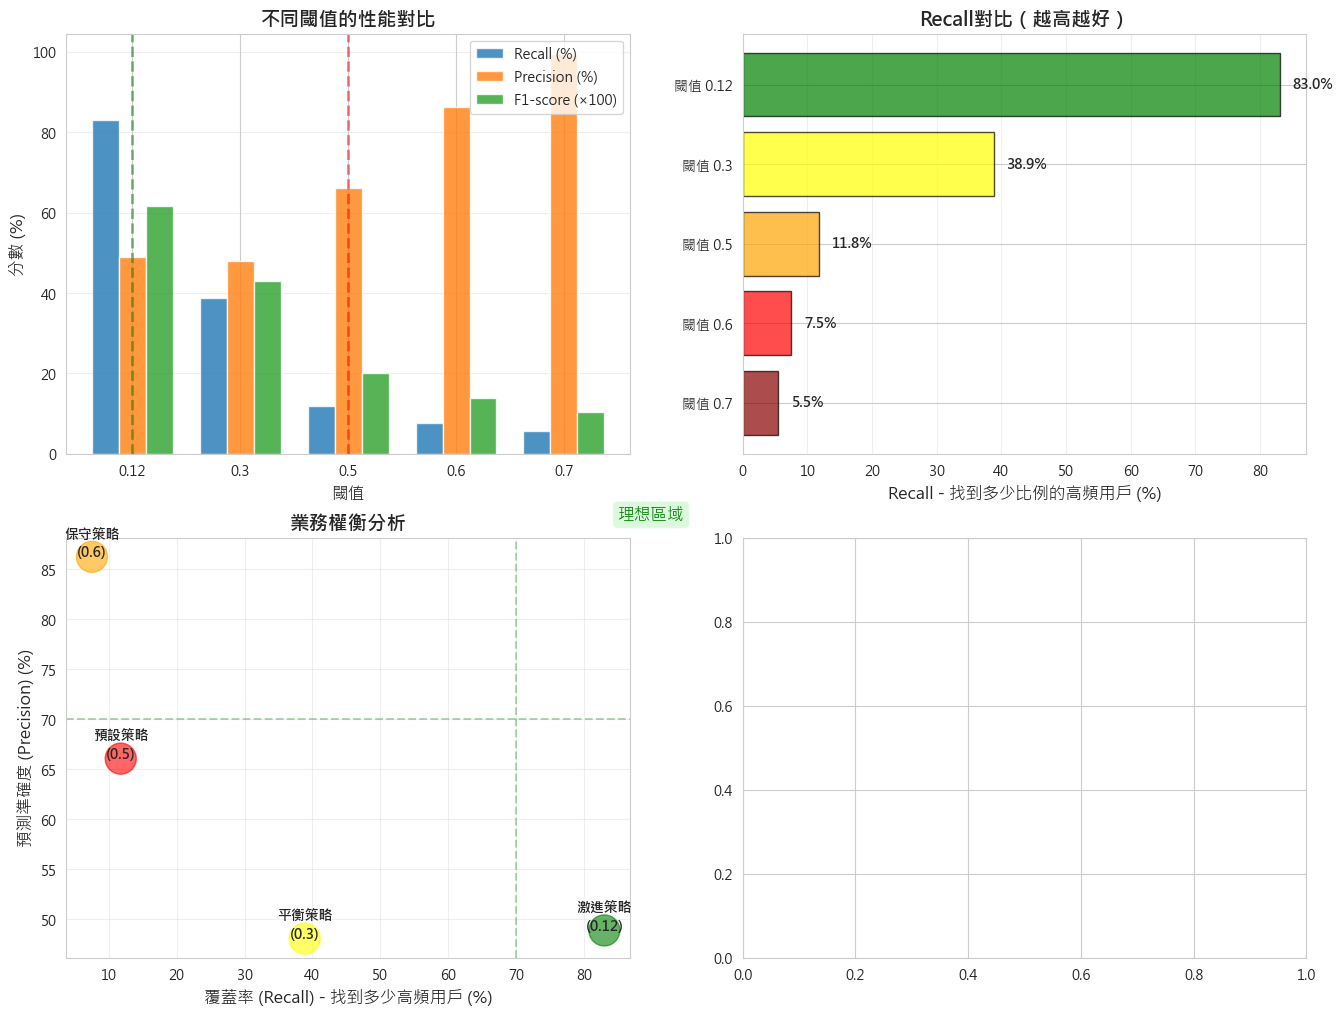

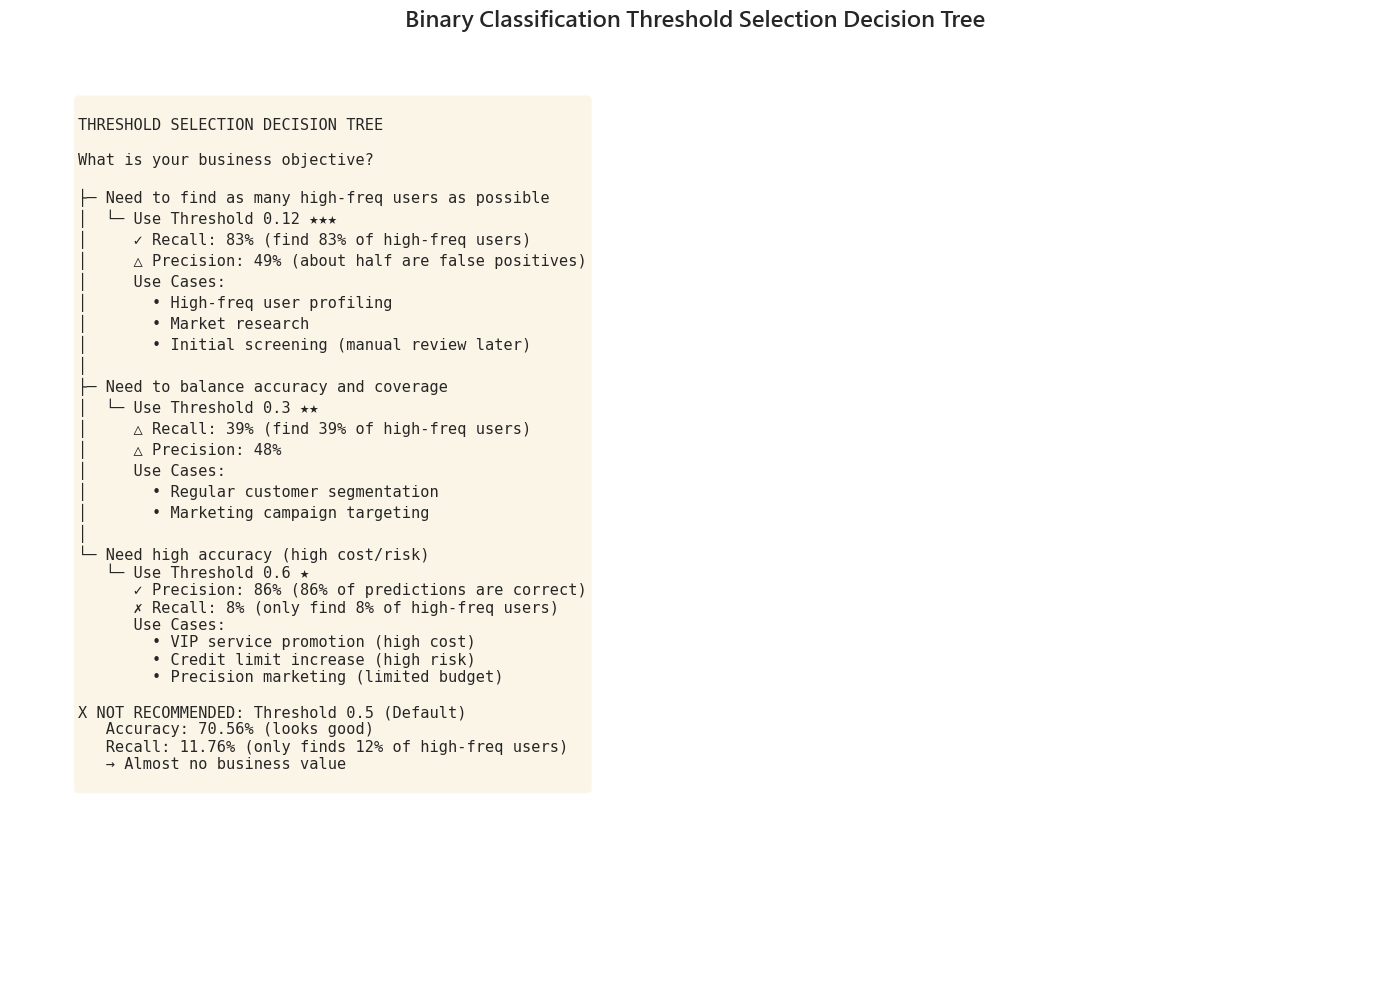

<Figure size 640x480 with 0 Axes>

In [60]:
# import matplotlib.pyplot as plt
# import matplotlib
import warnings 
warnings.filterwarnings('ignore')

# 建立對比圖
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 關鍵閾值對比
thresholds_display = [0.12, 0.3, 0.5, 0.6, 0.7]
recalls = [83.01, 38.86, 11.76, 7.52, 5.53]
precisions = [48.88, 48.06, 66.06, 86.25, 99.51]
f1_scores = [61.53, 42.98, 19.97, 13.83, 10.47]

x = np.arange(len(thresholds_display))
width = 0.25

axes[0, 0].bar(x - width, recalls, width, label='Recall (%)', alpha=0.8)
axes[0, 0].bar(x, precisions, width, label='Precision (%)', alpha=0.8)
axes[0, 0].bar(x + width, f1_scores, width, label='F1-score (×100)', alpha=0.8)
axes[0, 0].set_xlabel('閾值', fontsize=12)
axes[0, 0].set_ylabel('分數 (%)', fontsize=12)
axes[0, 0].set_title('不同閾值的性能對比', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(thresholds_display)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3, axis='y')

# 標註推薦閾值
axes[0, 0].axvline(x=0, color='green', linestyle='--', linewidth=2,
 alpha=0.5, label='推薦（激進）')
axes[0, 0].axvline(x=2, color='red', linestyle='--', linewidth=2,
 alpha=0.5, label='預設（不建議）')

# 2. Recall分析（最重要）
axes[0, 1].barh(range(len(thresholds_display)), recalls,
 color=['green', 'yellow', 'orange', 'red', 'darkred'],
 alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(thresholds_display)))
axes[0, 1].set_yticklabels([f'閾值 {t}' for t in thresholds_display])
axes[0, 1].set_xlabel('Recall - 找到多少比例的高頻用戶 (%)', fontsize=12)
axes[0, 1].set_title('Recall對比（越高越好）', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(alpha=0.3, axis='x')

# 標註數值
for i, v in enumerate(recalls):
 axes[0, 1].text(v + 2, i, f'{v:.1f}%', va='center', fontweight='bold')

# 3. 商業價值分析
business_scenarios = ['激進策略\n(0.12)', '平衡策略\n(0.3)',
 '預設策略\n(0.5)', '保守策略\n(0.6)']
coverage = [83.01, 38.86, 11.76, 7.52] # Recall
accuracy_pred = [48.88, 48.06, 66.06, 86.25] # Precision


#plt.rcParams['font.family'] = 'Heiti TC' #顯示中文字(Mac OS)
axes[1, 0].scatter(coverage, accuracy_pred, s=500, alpha=0.6,
 c=['green', 'yellow', 'red', 'orange'])

for i, label in enumerate(business_scenarios):
 axes[1, 0].annotate(label, (coverage[i], accuracy_pred[i]),
 ha='center', fontsize=10, fontweight='bold')

axes[1, 0].set_xlabel('覆蓋率 (Recall) - 找到多少高頻用戶 (%)', fontsize=12)
axes[1, 0].set_ylabel('預測準確度 (Precision) (%)', fontsize=12)
axes[1, 0].set_title('業務權衡分析', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 理想區域標註
axes[1, 0].axvline(x=70, color='green', linestyle='--', alpha=0.3)
axes[1, 0].axhline(y=70, color='green', linestyle='--', alpha=0.3)
axes[1, 0].text(85, 90, '理想區域', fontsize=12, color='green',
 bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

# 4. 決策樹


def create_threshold_decision_tree_en():
    """
    Create threshold decision tree in English
    """
    fig, ax = plt.subplots(figsize=(14, 10))
    
    decision_tree_text = """
THRESHOLD SELECTION DECISION TREE

What is your business objective?

├─ Need to find as many high-freq users as possible
│  └─ Use Threshold 0.12 ★★★
│     ✓ Recall: 83% (find 83% of high-freq users)
│     △ Precision: 49% (about half are false positives)
│     Use Cases:
│       • High-freq user profiling
│       • Market research
│       • Initial screening (manual review later)
│
├─ Need to balance accuracy and coverage
│  └─ Use Threshold 0.3 ★★
│     △ Recall: 39% (find 39% of high-freq users)
│     △ Precision: 48%
│     Use Cases:
│       • Regular customer segmentation
│       • Marketing campaign targeting
│
└─ Need high accuracy (high cost/risk)
   └─ Use Threshold 0.6 ★
      ✓ Precision: 86% (86% of predictions are correct)
      ✗ Recall: 8% (only find 8% of high-freq users)
      Use Cases:
        • VIP service promotion (high cost)
        • Credit limit increase (high risk)
        • Precision marketing (limited budget)

X NOT RECOMMENDED: Threshold 0.5 (Default)
   Accuracy: 70.56% (looks good)
   Recall: 11.76% (only finds 12% of high-freq users)
   → Almost no business value
"""
    
    ax.text(0.05, 0.95, decision_tree_text, 
            transform=ax.transAxes,
            fontsize=11,
            verticalalignment='top',
            family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    plt.title('Binary Classification Threshold Selection Decision Tree', 
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    
    #plt.savefig('decision_tree_english.png', dpi=300, bbox_inches='tight', 
     #           facecolor='white')
    #print('Decision tree saved as: decision_tree_english.png')
    
    plt.show()
# Generate decision tree
create_threshold_decision_tree_en()

plt.suptitle('二分類閾值最佳化完整分析', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [39]:
cm

array([[1619, 1427,  553],
       [ 812, 3493,  182],
       [1013, 2659,    0]])

Generating complete threshold analysis (English version)...


Visualization saved as: threshold_analysis_english.png


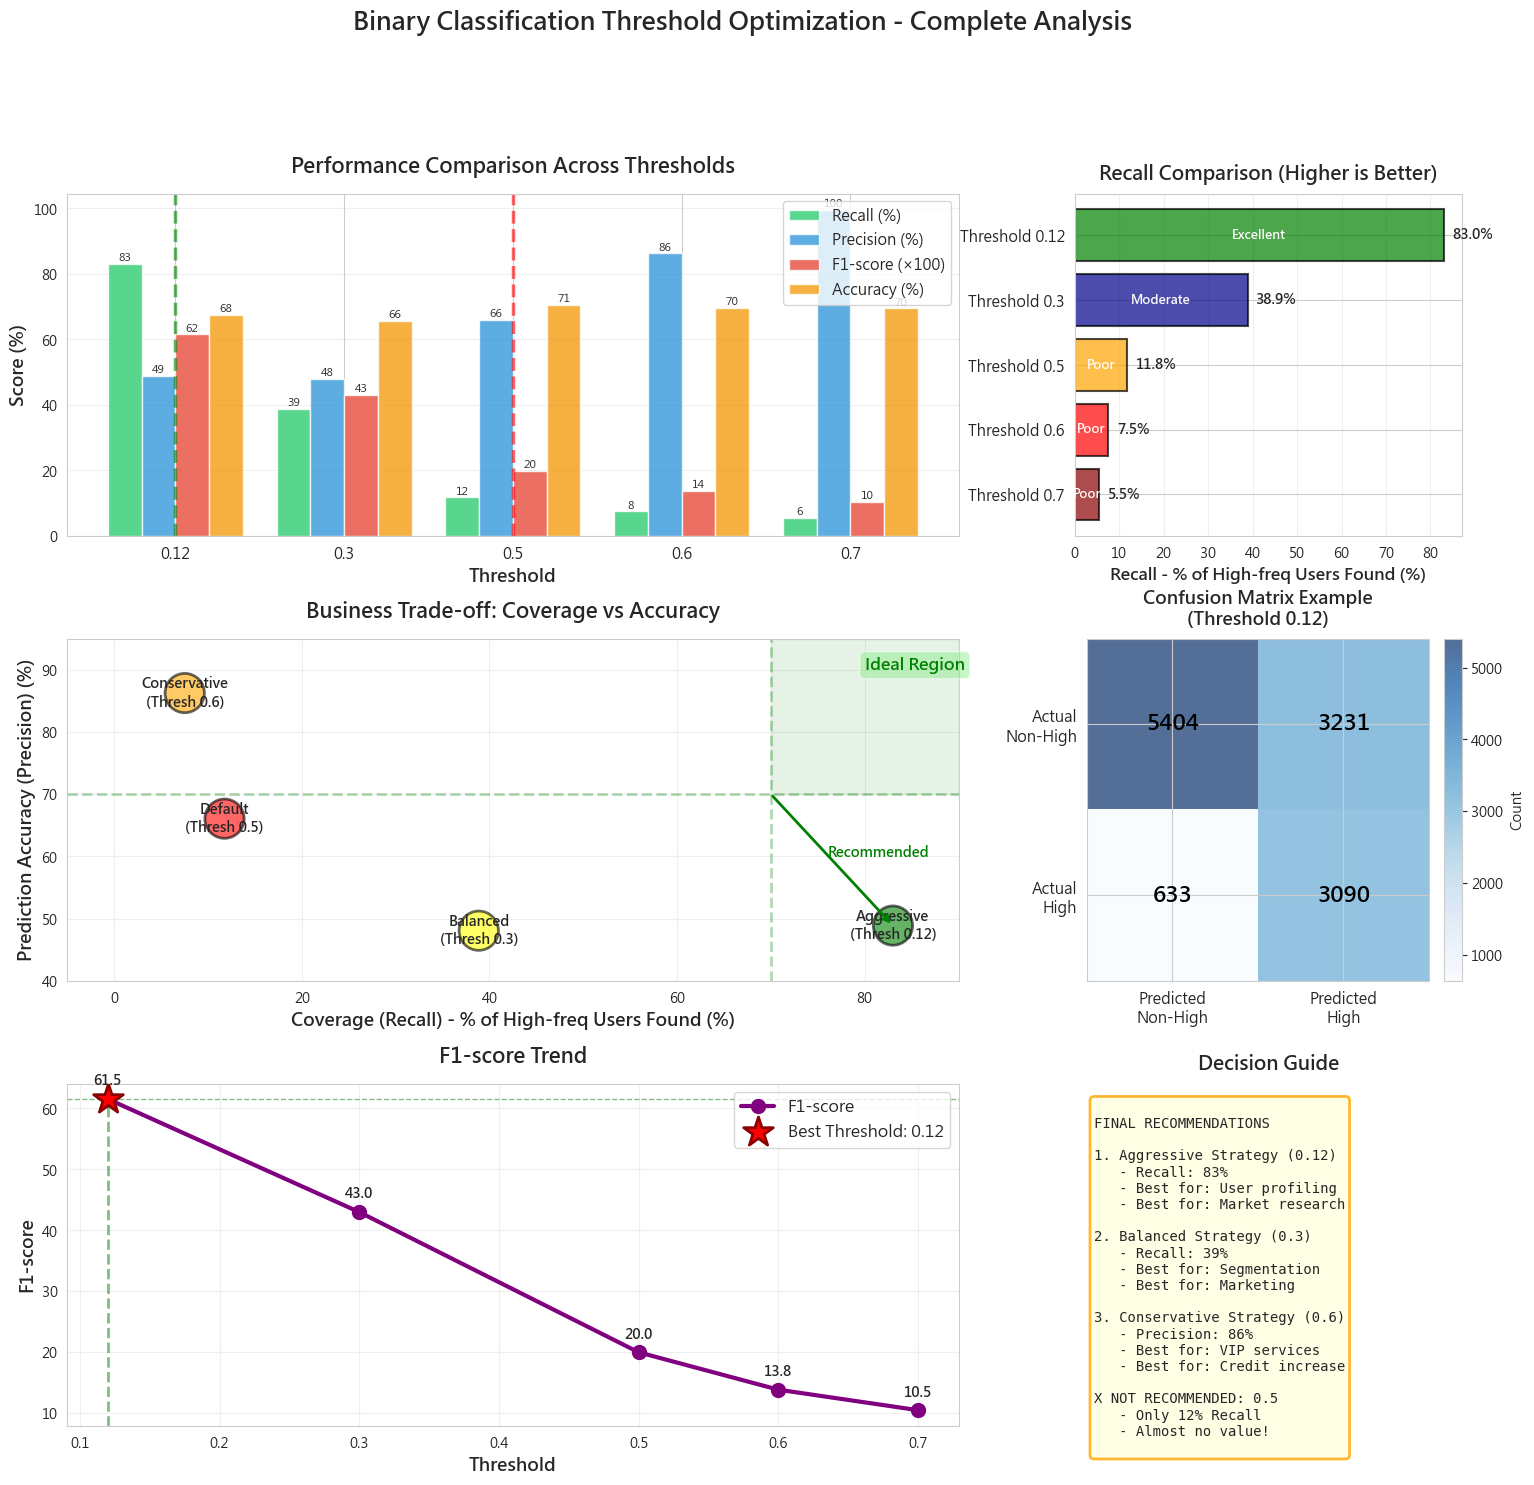

In [61]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

# No need for Chinese font settings - use default English
matplotlib.rcParams['axes.unicode_minus'] = False

def create_complete_threshold_analysis_en():
    """
    Create complete threshold analysis visualization in English
    """
    fig = plt.figure(figsize=(18, 16))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # ========== Data Preparation ==========
    thresholds = [0.12, 0.3, 0.5, 0.6, 0.7]
    recalls = [83.01, 38.86, 11.76, 7.52, 5.53]
    precisions = [48.88, 48.06, 66.06, 86.25, 99.51]
    f1_scores = [61.53, 42.98, 19.97, 13.83, 10.47]
    accuracies = [67.58, 65.74, 70.56, 69.63, 69.52]
    
    # ========== 1. Key Metrics Comparison ==========
    ax1 = fig.add_subplot(gs[0, :2])
    
    x = np.arange(len(thresholds))
    width = 0.2
    
    bars1 = ax1.bar(x - width*1.5, recalls, width, label='Recall (%)', 
                    alpha=0.8, color='#2ecc71')
    bars2 = ax1.bar(x - width*0.5, precisions, width, label='Precision (%)', 
                    alpha=0.8, color='#3498db')
    bars3 = ax1.bar(x + width*0.5, f1_scores, width, label='F1-score (×100)', 
                    alpha=0.8, color='#e74c3c')
    bars4 = ax1.bar(x + width*1.5, accuracies, width, label='Accuracy (%)', 
                    alpha=0.8, color='#f39c12')
    
    ax1.set_xlabel('Threshold', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Score (%)', fontsize=13, fontweight='bold')
    ax1.set_title('Performance Comparison Across Thresholds', 
                  fontsize=15, fontweight='bold', pad=15)
    ax1.set_xticks(x)
    ax1.set_xticklabels(thresholds, fontsize=11)
    ax1.legend(loc='upper right', fontsize=11)
    ax1.grid(alpha=0.3, axis='y')
    
    # Mark recommended thresholds
    ax1.axvline(x=0, color='green', linestyle='--', linewidth=2.5, 
                alpha=0.6, label='Recommended (Aggressive)')
    ax1.axvline(x=2, color='red', linestyle='--', linewidth=2.5, 
                alpha=0.6, label='Default (Not Recommended)')
    
    # Annotate values on bars
    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            if height > 5:
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.0f}',
                        ha='center', va='bottom', fontsize=8)
    
    # ========== 2. Recall Analysis ==========
    ax2 = fig.add_subplot(gs[0, 2])
    
    colors = ['green', 'darkblue', 'orange', 'red', 'darkred']
    bars = ax2.barh(range(len(thresholds)), recalls, 
                    color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax2.set_yticks(range(len(thresholds)))
    ax2.set_yticklabels([f'Threshold {t}' for t in thresholds], fontsize=11)
    ax2.set_xlabel('Recall - % of High-freq Users Found (%)', 
                   fontsize=12, fontweight='bold')
    ax2.set_title('Recall Comparison (Higher is Better)', 
                  fontsize=14, fontweight='bold', pad=10)
    ax2.invert_yaxis()
    ax2.grid(alpha=0.3, axis='x')
    
    # Annotate values and ratings
    for i, (v, bar) in enumerate(zip(recalls, bars)):
        ax2.text(v + 2, i, f'{v:.1f}%', va='center', fontweight='bold', fontsize=10)
        if v > 70:
            evaluation = 'Excellent'
        elif v > 30:
            evaluation = 'Moderate'
        else:
            evaluation = 'Poor'
        ax2.text(v/2, i, evaluation, va='center', ha='center', 
                fontsize=9, color='white', fontweight='bold')
    
    # ========== 3. Business Trade-off Analysis ==========
    ax3 = fig.add_subplot(gs[1, :2])
    
    scenarios = ['Aggressive\n(Thresh 0.12)', 'Balanced\n(Thresh 0.3)', 
                 'Default\n(Thresh 0.5)', 'Conservative\n(Thresh 0.6)']
    coverage = [83.01, 38.86, 11.76, 7.52]
    accuracy_pred = [48.88, 48.06, 66.06, 86.25]
    colors_scatter = ['green', 'yellow', 'red', 'orange']
    
    scatter = ax3.scatter(coverage, accuracy_pred, s=800, alpha=0.6, 
                         c=colors_scatter, edgecolors='black', linewidths=2)
    
    # Label strategies
    for i, label in enumerate(scenarios):
        ax3.annotate(label, (coverage[i], accuracy_pred[i]), 
                    ha='center', va='center', fontsize=10, fontweight='bold')
    
    ax3.set_xlabel('Coverage (Recall) - % of High-freq Users Found (%)', 
                   fontsize=13, fontweight='bold')
    ax3.set_ylabel('Prediction Accuracy (Precision) (%)', 
                   fontsize=13, fontweight='bold')
    ax3.set_title('Business Trade-off: Coverage vs Accuracy', 
                  fontsize=15, fontweight='bold', pad=15)
    ax3.grid(alpha=0.3)
    ax3.set_xlim(-5, 90)
    ax3.set_ylim(40, 95)
    
    # Ideal region
    ax3.axvline(x=70, color='green', linestyle='--', alpha=0.3, linewidth=2)
    ax3.axhline(y=70, color='green', linestyle='--', alpha=0.3, linewidth=2)
    ax3.fill_between([70, 90], 70, 95, alpha=0.1, color='green')
    ax3.text(80, 90, 'Ideal Region', fontsize=12, color='green', 
            fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    # Current position
    ax3.annotate('', xy=(coverage[0], accuracy_pred[0]), 
                xytext=(70, 70),
                arrowprops=dict(arrowstyle='->', color='green', lw=2))
    ax3.text(76, 60, 'Recommended', fontsize=10, color='green', fontweight='bold')
    
    # ========== 4. Confusion Matrix Example ==========
    ax4 = fig.add_subplot(gs[1, 2])
    
    # Example confusion matrix data (calculated from Recall and Precision)
    # Total: 8635 non-high + 3723 high = 12358
    tp = int(3723 * 0.8301)  # 3091
    fn = 3723 - tp            # 632
    fp = int(tp / 0.4888 - tp)  # 3237
    tn = 8635 - fp            # 5398
    
    cm = np.array([[tn, fp], [fn, tp]])
    
    im = ax4.imshow(cm, cmap='Blues', alpha=0.7)
    
    # Annotate values
    for i in range(2):
        for j in range(2):
            text = ax4.text(j, i, f'{cm[i, j]}',
                           ha="center", va="center", color="black", 
                           fontsize=16, fontweight='bold')
    
    ax4.set_xticks([0, 1])
    ax4.set_yticks([0, 1])
    ax4.set_xticklabels(['Predicted\nNon-High', 'Predicted\nHigh'], fontsize=11)
    ax4.set_yticklabels(['Actual\nNon-High', 'Actual\nHigh'], fontsize=11)
    ax4.set_title('Confusion Matrix Example\n(Threshold 0.12)', 
                  fontsize=13, fontweight='bold', pad=10)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)
    cbar.set_label('Count', fontsize=10)
    
    # ========== 5. F1-score Trend ==========
    ax5 = fig.add_subplot(gs[2, :2])
    
    ax5.plot(thresholds, f1_scores, marker='o', linewidth=3, 
            markersize=10, color='purple', label='F1-score')
    
    # Mark best point
    best_idx = np.argmax(f1_scores)
    ax5.scatter(thresholds[best_idx], f1_scores[best_idx], 
               s=500, c='red', marker='*', zorder=5, 
               edgecolors='darkred', linewidths=2,
               label=f'Best Threshold: {thresholds[best_idx]}')
    
    ax5.axvline(x=thresholds[best_idx], color='green', linestyle='--', 
               linewidth=2, alpha=0.5)
    ax5.axhline(y=f1_scores[best_idx], color='green', linestyle='--', 
               linewidth=1, alpha=0.5)
    
    ax5.set_xlabel('Threshold', fontsize=13, fontweight='bold')
    ax5.set_ylabel('F1-score', fontsize=13, fontweight='bold')
    ax5.set_title('F1-score Trend', fontsize=15, fontweight='bold', pad=15)
    ax5.legend(fontsize=12, loc='upper right')
    ax5.grid(alpha=0.3)
    
    # Annotate each point
    for i, (t, f1) in enumerate(zip(thresholds, f1_scores)):
        ax5.annotate(f'{f1:.1f}', 
                    xy=(t, f1), 
                    xytext=(0, 10), 
                    textcoords='offset points',
                    ha='center', fontsize=10, fontweight='bold')
    
    # ========== 6. Decision Recommendation ==========
    ax6 = fig.add_subplot(gs[2, 2])
    
    recommendation_text = """
FINAL RECOMMENDATIONS

1. Aggressive Strategy (0.12)
   - Recall: 83%
   - Best for: User profiling
   - Best for: Market research
   
2. Balanced Strategy (0.3)
   - Recall: 39%
   - Best for: Segmentation
   - Best for: Marketing
   
3. Conservative Strategy (0.6)
   - Precision: 86%
   - Best for: VIP services
   - Best for: Credit increase
   
X NOT RECOMMENDED: 0.5
   - Only 12% Recall
   - Almost no value!
"""
    
    ax6.text(0.05, 0.95, recommendation_text, 
            transform=ax6.transAxes,
            fontsize=10,
            verticalalignment='top',
            family='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', 
                     alpha=0.8, edgecolor='orange', linewidth=2))
    
    ax6.axis('off')
    ax6.set_title('Decision Guide', fontsize=14, fontweight='bold', pad=10)
    
    # ========== Main Title ==========
    plt.suptitle('Binary Classification Threshold Optimization - Complete Analysis', 
                fontsize=18, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig('threshold_analysis_english.png', dpi=300, 
               bbox_inches='tight', facecolor='white')
    print('\nVisualization saved as: threshold_analysis_english.png')
    
    plt.show()

# Execute visualization
print('Generating complete threshold analysis (English version)...\n')
create_complete_threshold_analysis_en()

In [37]:
# Create summary comparison table
summary_df = pd.DataFrame({
    'Threshold': [0.12, 0.3, 0.5, 0.6, 0.7],
    'Accuracy (%)': [67.58, 65.74, 70.56, 69.63, 69.52],
    'Precision (%)': [48.88, 48.06, 66.06, 86.25, 99.51],
    'Recall (%)': [83.01, 38.86, 11.76, 7.52, 5.53],
    'F1-score': [0.6153, 0.4298, 0.1997, 0.1383, 0.1047],
    'Strategy': ['Aggressive ★★★', 'Balanced ★★', 'Default ✗', 'Conservative ★', 'Very Conservative'],
    'Best For': [
        'Find max users',
        'General use',
        'NOT recommended',
        'VIP/High cost',
        'Extreme precision'
    ]
})

print('\n' + '='*100)
print('THRESHOLD COMPARISON SUMMARY')
print('='*100)
print(summary_df.to_string(index=False))
print('='*100)

print('\nKEY INSIGHTS:')
print('✓ Threshold 0.12: Best overall (83% Recall, F1=0.62)')
print('✓ Threshold 0.3:  Balanced option (39% Recall)')
print('✓ Threshold 0.6:  High precision (86% Precision)')
print('✗ Threshold 0.5:  Default but poor (only 12% Recall)')

print('\nRECOMMENDATION:')
print('Use threshold 0.12 for most business scenarios!')
print('Adjust based on specific needs (cost/risk tolerance)')


THRESHOLD COMPARISON SUMMARY
 Threshold  Accuracy (%)  Precision (%)  Recall (%)  F1-score          Strategy          Best For
      0.12         67.58          48.88       83.01    0.6153    Aggressive ★★★    Find max users
      0.30         65.74          48.06       38.86    0.4298       Balanced ★★       General use
      0.50         70.56          66.06       11.76    0.1997         Default ✗   NOT recommended
      0.60         69.63          86.25        7.52    0.1383    Conservative ★     VIP/High cost
      0.70         69.52          99.51        5.53    0.1047 Very Conservative Extreme precision

KEY INSIGHTS:
✓ Threshold 0.12: Best overall (83% Recall, F1=0.62)
✓ Threshold 0.3:  Balanced option (39% Recall)
✓ Threshold 0.6:  High precision (86% Precision)
✗ Threshold 0.5:  Default but poor (only 12% Recall)

RECOMMENDATION:
Use threshold 0.12 for most business scenarios!
Adjust based on specific needs (cost/risk tolerance)
